In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [2]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red", "orange"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")

In [3]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            # if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 135.8014900383613, p1: 77.46545346305896
t2: 123.45691588963366, p2: 210.27439136346118
n: [ 0.15130046  0.6805302  -0.71692874]
s: [-0.72051951 -0.42060571 -0.55130978]
内積 (n・s): -1.6293094719552355e-16


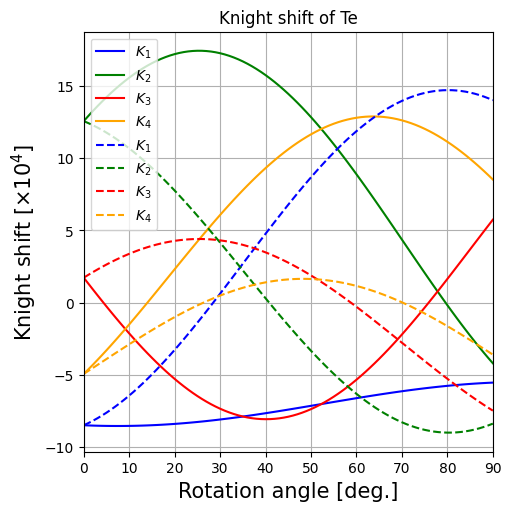

Angle,Shift1[1] value
0,-8.474529057325109
1,-8.487327786173626
2,-8.498315120760562
3,-8.507477674711192
4,-8.51480428486491
5,-8.520286024875825
6,-8.523916216088125
7,-8.525690435673011
8,-8.525606522017215
9,-8.5236645773566
10,-8.5198669676516
11,-8.514218319704668
12,-8.506725515523215
13,-8.49739768393496
14,-8.48624618946585
15,-8.473284618494143
16,-8.458528762697487
17,-8.441996599813208
18,-8.423708271735192
19,-8.403686059974106
20,-8.381954358510795
21,-8.358539644075977
22,-8.333470443892429
23,-8.306777300918965
24,-8.278492736638533
25,-8.248651211435806
26,-8.21728908261251
27,-8.184444560091645
28,-8.150157659864604
29,-8.114470155237806
30,-8.07742552593841
31,-8.039068905140926
32,-7.999447024479413
33,-7.958608157112175
34,-7.91660205890835
35,-7.8734799078280595
36,-7.829294241569937
37,-7.784098893562033
38,-7.737948927374088
39,-7.690900569631052
40,-7.643011141509578
41,-7.594338988901041
42,-7.544943411326022
43,-7.494884589686987
44,-7.444223512947133
45,-7.3

In [4]:
# In the case of Te. (Te1 is on y-bond).
ks = [-0.08e-2, 0.13e-2, -0.05e-2, -0.11e-2, 0.0, 0.0]

E = np.eye(3)
C4 = rotation_matrix([0,0,1], np.pi/2) # for V2.
C2 = rotation_matrix([0,0,1], np.pi) # for V3.
C4i = C4.T # for V4.

Rs = [E, C4, C2, C4i]

theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2)

In [5]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts*10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts*10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2)

In [6]:
# 回転行列(PyTorch版)
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

# 外積(PyTorch版)
def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

# 磁場ベクトル(PyTorch版)
def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

# モデル関数(PyTorch版)
def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C4 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([torch.pi / 2.0])) # for V2.
    C2 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([torch.pi])) # for V3.
    C4i = C4.T # for V4.

    Rs = [E, C4, C2, C4i]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [7]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv', 'sample(4).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv', 'sample4.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6, x7, x8 = x_tensors
y1, y2, y3, y4, y5, y6, y7, y8 = y_tensors

In [8]:
# 損失関数の定義
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return torch.sqrt(squared_diffs.mean())

In [9]:
# 損失関数の和
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [10]:
# 全ての順列を生成
permutations = list(itertools.permutations([0, 1, 2, 3]))

# 最適化のためのobjective関数
def objective(trial, perm):
    # Optunaでパラメータをサンプリング
    k1 = torch.tensor(trial.suggest_float('k1', -15, 15), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -15, 15), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -15, 15), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -15, 15), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', -180.0, 180.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]
    
    # 順列に基づいた出力の取得
    y_p1, y_p2, y_p3, y_p4 = [outputs[i]['shift1'][perm[i]] for i in range(4)]
    y_p5, y_p6, y_p7, y_p8 = [outputs[i+4]['shift2'][perm[i]] for i in range(4)]

    # 損失関数の計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6, y_p7, y7, y_p8, y8)

    return loss.item()

# 最適化ループ
max_global_iterations = 3  # グローバルな最大繰り返し回数
global_iteration = 0

# グローバルな最良結果を保存するための変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 損失関数が0.01以下になるまで以下の計算を繰り返す
while global_best_loss > 1e-2 and global_iteration < max_global_iterations:
    print(f"\nGlobal iteration {global_iteration + 1}")

    # 6通りの組み合わせごとにエポック計算を行うためのループ
    for perm in permutations:
        print(f"Evaluating combination: perm1={perm}, perm2={perm}")

        # 最適化のための変数初期化
        best_epoch0_loss = float('inf')
        best_params = None

        # Optunaを使用してパラメータを最適化
        for _ in range(3):
            # Optunaで最適化
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, perm), n_trials=100)

            # epoch0のLossが最小のパラメータを保持
            if study.best_value < best_epoch0_loss:
                best_epoch0_loss = study.best_value
                best_params = study.best_params

        # エポック計算 (各組み合わせごとに計算)
        if best_params is not None:
            print(f"Starting training for combination: perm1={perm}, perm2={perm}")

            # 最適化されたパラメータで初期化
            k1 = torch.nn.Parameter(torch.tensor(best_params['k1'], dtype=torch.float32))
            k2 = torch.nn.Parameter(torch.tensor(best_params['k2'], dtype=torch.float32))
            k3 = torch.nn.Parameter(torch.tensor(best_params['k3'], dtype=torch.float32))
            k4 = torch.nn.Parameter(torch.tensor(best_params['k4'], dtype=torch.float32))
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1 = torch.nn.Parameter(torch.tensor(best_params['t1'], dtype=torch.float32))
            p1 = torch.nn.Parameter(torch.tensor(best_params['p1'], dtype=torch.float32))
            t2 = torch.nn.Parameter(torch.tensor(best_params['t2'], dtype=torch.float32))
            p2 = torch.nn.Parameter(torch.tensor(best_params['p2'], dtype=torch.float32))
            
            # 既存のパラメータに新しい初期値を設定
            k1.data = torch.tensor(best_params['k1'], dtype=torch.float32)
            k2.data = torch.tensor(best_params['k2'], dtype=torch.float32)
            k3.data = torch.tensor(best_params['k3'], dtype=torch.float32)
            k4.data = torch.tensor(best_params['k4'], dtype=torch.float32)
            k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
            t1.data = torch.tensor(best_params['t1'], dtype=torch.float32)
            p1.data = torch.tensor(best_params['p1'], dtype=torch.float32)
            t2.data = torch.tensor(best_params['t2'], dtype=torch.float32)
            p2.data = torch.tensor(best_params['p2'], dtype=torch.float32)

            optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
            prev_loss = float('inf')

            # エポックごとのトレーニング
            best_params_during_epoch = None  # エポックごとの最良パラメータ
            best_epoch_loss = float('inf')  # 最良のロスを記録

            # Early Stopping を導入
            early_stopping_patience = 1000
            no_improvement_counter = 0

            # エポックごとのトレーニング
            for epoch in range(300000):
                optimizer.zero_grad()

                outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]

                y_p1, y_p2, y_p3, y_p4 = [outputs[i]['shift1'][perm[i]] for i in range(4)]
                y_p5, y_p6, y_p7, y_p8 = [outputs[i+4]['shift2'][perm[i]] for i in range(4)]

                loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6, y_p7, y7, y_p8, y8)

                if epoch == 0:
                    epoch0_loss = loss.item()
                    if epoch0_loss >= 35:
                        print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                        break
                
                # 最良のロスを持つ場合はパラメータを保存
                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {
                        'k1': k1.item(),
                        'k2': k2.item(),
                        'k3': k3.item(),
                        'k4': k4.item(),
                        'k5': k5.item(),
                        'k6': k6.item(),
                        't1': t1.item(),
                        'p1': p1.item(),
                        't2': t2.item(),
                        'p2': p2.item()
                    }

                if loss.item() > prev_loss:
                    print(f"Loss increased at epoch {epoch}. Stopping training.")
                    break

                prev_loss = loss.item()
                loss.backward()

                optimizer.step()

                # 学習率の更新
                scheduler.step()

                if loss.item() < best_epoch_loss:
                    best_epoch_loss = loss.item()
                    best_params_during_epoch = {...}  # 保存処理
                    no_improvement_counter = 0  # リセット
                else:
                    no_improvement_counter += 1

                if no_improvement_counter >= early_stopping_patience:
                    print(f"Stopping early at epoch {epoch} due to no improvement.")
                    break

                with torch.no_grad():
                    for param in [k1, k2, k3]:
                        param.data = torch.clamp(param.data, -15, 15)
                    for param in [k4]:
                        param.data = torch.clamp(param.data, -15, 15)
                    for param in [t1, t2]:
                        param.data = torch.clamp(param.data, 0.0, 180.0)
                    for param in [p1]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)
                    for param in [p2]:
                        param.data = torch.clamp(param.data, -180.0, 180.0)

                if epoch % 100 == 0:
                    # 勾配を確認（必要に応じて）
                    # for name, param in zip(['k1', 'k2', 'k3', 'k4', 't1', 'p1', 't2', 'p2'], [k1, k2, k3, k4, t1, p1, t2, p2]):
                    #     print(f"{name} grad: {param.grad}")
                    print(f'Epoch {epoch}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()}')
                    # パラメータを表示する
                    print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

            # 最良のパラメータを表示
            if best_params_during_epoch is not None:
                print(f"Best params during epoch training: {best_params_during_epoch}")
                # 最良のパラメータをTensorに変換して使用
                k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
            else:
                print("No improvement in loss during epoch training.")

            # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
            if prev_loss < global_best_loss:
                global_best_loss = prev_loss
                global_best_params = best_params_during_epoch
                global_best_combination = (perm, perm)

            print(f"Finished training for combination: perm1={perm}, perm2={perm}")


    print(f"Global best Loss after iteration {global_iteration + 1}: {global_best_loss}")
    global_iteration += 1

print(f"\nOptimization completed.")
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2025-01-14 20:06:24,765] A new study created in memory with name: no-name-cc08e14a-6e68-4846-a8b7-c0f6f2140d1f



Global iteration 1
Evaluating combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)


[I 2025-01-14 20:06:24,894] Trial 0 finished with value: 83.77332305908203 and parameters: {'k1': 1.297863361072988, 'k2': -9.33538526287652, 'k3': 10.198180436400548, 'k4': -9.892574115261395, 't1': 56.53868634028471, 'p1': -85.55352356136851, 't2': 43.17396628166097, 'p2': 107.09666841766472}. Best is trial 0 with value: 83.77332305908203.
[I 2025-01-14 20:06:24,962] Trial 1 finished with value: 75.67143249511719 and parameters: {'k1': -9.220604337201742, 'k2': -5.604380741565295, 'k3': 12.183402135762144, 'k4': -0.023366513519395227, 't1': 35.34303310189339, 'p1': -29.990992026001265, 't2': 10.973813937145007, 'p2': -49.694963259772095}. Best is trial 1 with value: 75.67143249511719.
[I 2025-01-14 20:06:25,079] Trial 2 finished with value: 90.60844421386719 and parameters: {'k1': 12.624169205348828, 'k2': 10.30453854851585, 'k3': 10.843725133399975, 'k4': -5.705376374189692, 't1': 90.34028350719876, 'p1': 89.58073600050471, 't2': 47.37398313224835, 'p2': -106.10361767927103}. Best i

Starting training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)


[I 2025-01-14 20:06:51,235] A new study created in memory with name: no-name-441005a1-5630-4f14-a13c-d102bed3dc73
[I 2025-01-14 20:06:51,298] Trial 0 finished with value: 69.26168060302734 and parameters: {'k1': -6.526679929916504, 'k2': 0.7713438109044475, 'k3': -2.0717579899044782, 'k4': -11.606103458374918, 't1': 146.85325803066837, 'p1': -60.834622547004116, 't2': 169.11154166149993, 'p2': -36.74423293279432}. Best is trial 0 with value: 69.26168060302734.
[I 2025-01-14 20:06:51,357] Trial 1 finished with value: 76.60520935058594 and parameters: {'k1': -8.562598337404193, 'k2': -1.618297609706726, 'k3': -7.315843666864989, 'k4': -10.327159677277898, 't1': 101.58088785656837, 'p1': 111.48004587265677, 't2': 1.2130511770967933, 'p2': -103.28081330281064}. Best is trial 0 with value: 69.26168060302734.
[I 2025-01-14 20:06:51,416] Trial 2 finished with value: 60.963233947753906 and parameters: {'k1': 0.6026107805448575, 'k2': 2.703301299279815, 'k3': 2.3762631111098678, 'k4': 4.3181925

Epoch 0 Loss is 43.2218132019043, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Evaluating combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)


[I 2025-01-14 20:06:51,478] Trial 3 finished with value: 76.2162094116211 and parameters: {'k1': 6.779480101615064, 'k2': -5.623915005572924, 'k3': 14.059517014493995, 'k4': 11.770211015528915, 't1': 94.38320897655336, 'p1': -39.440153427065724, 't2': 170.305227217176, 'p2': -38.417324606861655}. Best is trial 2 with value: 60.963233947753906.
[I 2025-01-14 20:06:51,597] Trial 4 finished with value: 73.24980163574219 and parameters: {'k1': -7.3338979085568825, 'k2': -8.631916276668441, 'k3': 5.663474546359787, 'k4': 0.12094824592282016, 't1': 159.28369402553577, 'p1': 167.7047377393975, 't2': 77.61485316408788, 'p2': 168.0561269323843}. Best is trial 2 with value: 60.963233947753906.
[I 2025-01-14 20:06:51,656] Trial 5 finished with value: 72.84443664550781 and parameters: {'k1': 13.65399136507061, 'k2': 3.085266720320341, 'k3': 6.515157083999576, 'k4': -5.951515413217143, 't1': 175.75671944064757, 'p1': -164.49790593448415, 't2': 82.8882026254232, 'p2': 93.72910545661426}. Best is tri

Starting training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Epoch 0 Loss is 39.149784088134766, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Evaluating combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)


[I 2025-01-14 20:07:18,280] Trial 2 finished with value: 52.44105529785156 and parameters: {'k1': 13.591252159708365, 'k2': -13.133801309910961, 'k3': 2.0707193161211315, 'k4': 8.51549401679664, 't1': 51.28341915594033, 'p1': -36.15176875688766, 't2': 153.24385620371598, 'p2': 155.21911331995494}. Best is trial 2 with value: 52.44105529785156.
[I 2025-01-14 20:07:18,397] Trial 3 finished with value: 119.23839569091797 and parameters: {'k1': -9.851677029338669, 'k2': -12.975155778190551, 'k3': -10.765117792304057, 'k4': -13.639422878912526, 't1': 94.86807913186453, 'p1': -77.27971886394097, 't2': 83.20477294415184, 'p2': -153.5643562064152}. Best is trial 2 with value: 52.44105529785156.
[I 2025-01-14 20:07:18,456] Trial 4 finished with value: 89.17173767089844 and parameters: {'k1': -0.4682651587449893, 'k2': -3.5375094091816415, 'k3': 9.972350642464367, 'k4': -14.772018455792873, 't1': 138.20788356109134, 'p1': -41.300750355705105, 't2': 27.4136245896913, 'p2': -155.47255113934938}. B

Starting training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Epoch 0, Loss: 34.30406951904297, LR: [0.1]
Parameters: k1=-1.4005193710327148, k2=4.481251239776611, k3=1.4810281991958618, k4=12.658782005310059, k5=0.0, k6=0.0, t1=129.3115997314453, p1=92.55573272705078, t2=161.33477783203125, p2=64.83642578125
Epoch 100, Loss: 24.026151657104492, LR: [0.1]
Parameters: k1=-8.001649856567383, k2=14.787554740905762, k3=1.0356935262680054, k4=14.710732460021973, k5=0.0, k6=0.0, t1=118.24960327148438, p1=84.90365600585938, t2=159.77801513671875, p2=73.414794921875
Epoch 200, Loss: 16.90005111694336, LR: [0.1]
Parameters: k1=-10.738659858703613, k2=15.0, k3=1.4092692136764526, k4=14.673216819763184, k5=0.0, k6=0.0, t1=106.34846496582031, p1=86.12126159667969, t2=155.19410705566406, p2=77.6488037109375
Epoch 300, Loss: 12.485990524291992, LR: [0.1]
Parameters: k1=-9.95130443572998, k2=13.412672996520996, k3=1.7057195901870728, k4=14.211424827575684, k5=0.0, k6=0.0, t1=97.0103836059

[I 2025-01-14 20:09:56,791] A new study created in memory with name: no-name-fcaaa776-96d6-4b25-bebd-360e539a8a7a
[I 2025-01-14 20:09:56,919] Trial 0 finished with value: 100.00840759277344 and parameters: {'k1': 14.542803796317184, 'k2': -13.546458202782004, 'k3': -14.973194130925531, 'k4': 12.575801465452663, 't1': 137.7700091563297, 'p1': 38.65456455166637, 't2': 159.9402337592483, 'p2': -127.96462071090946}. Best is trial 0 with value: 100.00840759277344.
[I 2025-01-14 20:09:56,989] Trial 1 finished with value: 64.26492309570312 and parameters: {'k1': 11.790826087257187, 'k2': -6.375751304237177, 'k3': 5.818213603165102, 'k4': -9.127006676955116, 't1': 78.8882639926704, 'p1': 105.65025248087613, 't2': 6.201931076637526, 'p2': 151.69483624250455}. Best is trial 1 with value: 64.26492309570312.


Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': -8.633246421813965, 'k2': 11.1959867477417, 'k3': 1.8553342819213867, 'k4': 13.804067611694336, 'k5': 0.0, 'k6': 0.0, 't1': 79.4056167602539, 'p1': 81.15950775146484, 't2': 147.2877197265625, 'p2': 74.58531188964844}
Finished training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Evaluating combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)


[I 2025-01-14 20:09:57,060] Trial 2 finished with value: 54.04093551635742 and parameters: {'k1': 4.160422204110489, 'k2': 9.203582901127152, 'k3': -8.117938349302435, 'k4': 6.090367559749488, 't1': 177.4629593623199, 'p1': 1.5269022615246683, 't2': 70.43737210177217, 'p2': -90.18094405516818}. Best is trial 2 with value: 54.04093551635742.
[I 2025-01-14 20:09:57,130] Trial 3 finished with value: 73.69824981689453 and parameters: {'k1': 2.85914114007236, 'k2': 1.5702876642938328, 'k3': -9.373130219477336, 'k4': -2.7716622242249844, 't1': 132.25283086577784, 'p1': -121.91276988914827, 't2': 7.866694176575555, 'p2': 162.55373579358712}. Best is trial 2 with value: 54.04093551635742.
[I 2025-01-14 20:09:57,198] Trial 4 finished with value: 74.30717468261719 and parameters: {'k1': -7.074024382333216, 'k2': -7.5404272986366525, 'k3': 1.3968252304415039, 'k4': 7.831274111855841, 't1': 105.70822262144648, 'p1': 41.478144385989765, 't2': 46.302769310319604, 'p2': -36.116228396304734}. Best is 

Starting training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Epoch 0, Loss: 31.938541412353516, LR: [0.1]
Parameters: k1=-4.9667510986328125, k2=-1.9783309698104858, k3=3.8754894733428955, k4=-13.090879440307617, k5=0.0, k6=0.0, t1=174.45989990234375, p1=-28.16176986694336, t2=33.29697799682617, p2=110.04893493652344
Epoch 100, Loss: 25.199134826660156, LR: [0.1]
Parameters: k1=-13.198541641235352, k2=6.455081939697266, k3=3.070880889892578, k4=-13.048724174499512, k5=0.0, k6=0.0, t1=180.0, p1=-23.01076889038086, t2=33.22153091430664, p2=101.42500305175781
Epoch 200, Loss: 24.90826988220215, LR: [0.1]
Parameters: k1=-15.0, k2=8.342595100402832, k3=2.8808515071868896, k4=-13.5285062789917, k5=0.0, k6=0.0, t1=180.0, p1=-23.00318717956543, t2=31.697940826416016, p2=99.7607421875


[I 2025-01-14 20:10:58,247] A new study created in memory with name: no-name-41830b16-838b-4659-93db-a60c0ee00c5c
[I 2025-01-14 20:10:58,318] Trial 0 finished with value: 100.46913146972656 and parameters: {'k1': -7.34397972593098, 'k2': 5.981293874306612, 'k3': -14.747007076453384, 'k4': -7.172538300210346, 't1': 135.77112127342696, 'p1': 93.78772168185765, 't2': 18.49016425692609, 'p2': -96.2532709814414}. Best is trial 0 with value: 100.46913146972656.
[I 2025-01-14 20:10:58,383] Trial 1 finished with value: 87.21440887451172 and parameters: {'k1': 2.792341157056814, 'k2': -11.576644463419111, 'k3': -3.652451202742755, 'k4': -3.9375693880108855, 't1': 98.31726951530614, 'p1': 120.92524011715261, 't2': 63.53620183452155, 'p2': -5.036751559012231}. Best is trial 1 with value: 87.21440887451172.


Loss increased at epoch 261. Stopping training.
Best params during epoch training: {'k1': -15.0, 'k2': 8.55649471282959, 'k3': 2.8438785076141357, 'k4': -13.554482460021973, 'k5': 0.0, 'k6': 0.0, 't1': 180.0, 'p1': -23.00318717956543, 't2': 31.62484359741211, 'p2': 99.7244644165039}
Finished training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Evaluating combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)


[I 2025-01-14 20:10:58,454] Trial 2 finished with value: 72.093017578125 and parameters: {'k1': -0.4692669211414877, 'k2': -1.8914024756653731, 'k3': 5.012409431236016, 'k4': -8.907984813680002, 't1': 32.302488982117545, 'p1': -157.24362775073732, 't2': 63.63308427585888, 'p2': -132.82167071713985}. Best is trial 2 with value: 72.093017578125.
[I 2025-01-14 20:10:58,521] Trial 3 finished with value: 95.20584106445312 and parameters: {'k1': -12.558923232735417, 'k2': -14.33947648846351, 'k3': -5.807634860121876, 'k4': -3.8175910956651204, 't1': 43.679393963916965, 'p1': 66.88000384750265, 't2': 62.066382388549016, 'p2': 81.48584340515322}. Best is trial 2 with value: 72.093017578125.
[I 2025-01-14 20:10:58,647] Trial 4 finished with value: 67.0019760131836 and parameters: {'k1': -10.6800049467921, 'k2': -3.20102028778388, 'k3': 9.307336413115351, 'k4': -3.2862465551906848, 't1': 114.11721508407916, 'p1': 148.07919796078158, 't2': 54.120275720143255, 'p2': -7.710997977553433}. Best is tr

Starting training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Epoch 0 Loss is 39.95212936401367, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Evaluating combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)


[I 2025-01-14 20:11:25,153] Trial 2 finished with value: 77.50987243652344 and parameters: {'k1': -5.947411957373932, 'k2': 7.920171210629217, 'k3': 8.182605457029474, 'k4': 14.364845253053652, 't1': 15.620359695372079, 'p1': -71.66932918774572, 't2': 153.95626365365715, 'p2': 77.6509371514602}. Best is trial 2 with value: 77.50987243652344.
[I 2025-01-14 20:11:25,255] Trial 3 finished with value: 112.80987548828125 and parameters: {'k1': -11.112879259241641, 'k2': -11.843778301203876, 'k3': 1.3136347939588013, 'k4': 13.055163661166503, 't1': 115.89248155680299, 'p1': 128.77519827976914, 't2': 158.97812083422832, 'p2': -58.233249078459025}. Best is trial 2 with value: 77.50987243652344.
[I 2025-01-14 20:11:25,325] Trial 4 finished with value: 72.85763549804688 and parameters: {'k1': -6.509019363426358, 'k2': -7.261198586721001, 'k3': -3.196905214026321, 'k4': 8.32216300534725, 't1': 120.03888000679662, 'p1': -144.28532687397936, 't2': 62.87292649708993, 'p2': -136.11510226910877}. Best

Starting training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Epoch 0 Loss is 39.48759460449219, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Evaluating combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)


[I 2025-01-14 20:11:51,891] Trial 1 finished with value: 108.30192565917969 and parameters: {'k1': -8.771408348184076, 'k2': 4.342741548745863, 'k3': -12.623432891035296, 'k4': 9.049621478959356, 't1': 128.41133007597958, 'p1': -62.7108822183835, 't2': 26.760271420287715, 'p2': 20.407594651601045}. Best is trial 0 with value: 93.68062591552734.
[I 2025-01-14 20:11:51,960] Trial 2 finished with value: 70.16936492919922 and parameters: {'k1': -6.3425560882223575, 'k2': 8.059394713635282, 'k3': 2.771813685123721, 'k4': 8.681708692119766, 't1': 50.18081230130107, 'p1': 22.021287607304203, 't2': 139.3314444720295, 'p2': 166.99635157191784}. Best is trial 2 with value: 70.16936492919922.
[I 2025-01-14 20:11:52,034] Trial 3 finished with value: 85.96330261230469 and parameters: {'k1': 8.978226840770358, 'k2': -6.495963677672229, 'k3': -9.309671503850222, 'k4': -6.943331916695307, 't1': 95.31698721700444, 'p1': -20.26092973997345, 't2': 127.69240150018464, 'p2': -82.76758159671476}. Best is tr

Starting training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Epoch 0 Loss is 37.84479522705078, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Evaluating combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)


[I 2025-01-14 20:12:18,197] Trial 1 finished with value: 63.95189666748047 and parameters: {'k1': 5.940770298927376, 'k2': 0.2269356165102252, 'k3': -1.6141989875600675, 'k4': 13.265304141786718, 't1': 15.735439592844111, 'p1': -142.9274377881035, 't2': 160.2686067327013, 'p2': -122.30084876824813}. Best is trial 1 with value: 63.95189666748047.
[I 2025-01-14 20:12:18,267] Trial 2 finished with value: 59.48539352416992 and parameters: {'k1': 5.272143920275862, 'k2': 4.121787521258458, 'k3': 9.266659174348224, 'k4': 9.578518357530449, 't1': 43.86532889810012, 'p1': 51.02522449465951, 't2': 68.90425858592913, 'p2': 8.039611114561382}. Best is trial 2 with value: 59.48539352416992.
[I 2025-01-14 20:12:18,335] Trial 3 finished with value: 68.90089416503906 and parameters: {'k1': 3.158500023089225, 'k2': 2.8412225131185416, 'k3': 12.697337949778323, 'k4': -9.209181176358515, 't1': 30.771862489400768, 'p1': 11.632161826961209, 't2': 93.85792004978269, 'p2': 157.39443498416455}. Best is trial

Starting training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Epoch 0 Loss is 38.19975662231445, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Evaluating combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)


[I 2025-01-14 20:12:44,774] Trial 1 finished with value: 69.19712829589844 and parameters: {'k1': -2.9237706999389363, 'k2': 9.543248457550085, 'k3': -12.006790749359013, 'k4': -4.847958018593035, 't1': 1.5703436757695766, 'p1': -87.6951052390709, 't2': 75.96490006265269, 'p2': 153.32456314470943}. Best is trial 0 with value: 59.8298454284668.
[I 2025-01-14 20:12:44,843] Trial 2 finished with value: 70.54498291015625 and parameters: {'k1': 5.63038860553921, 'k2': -11.68043196290234, 'k3': 3.8636944728439353, 'k4': -14.680965419607805, 't1': 161.12675815294622, 'p1': 55.95769861511437, 't2': 173.8120798814677, 'p2': -17.048503327274403}. Best is trial 0 with value: 59.8298454284668.
[I 2025-01-14 20:12:44,909] Trial 3 finished with value: 53.64352798461914 and parameters: {'k1': -0.5078399542998984, 'k2': 11.205188841171086, 'k3': 1.8962088287651326, 'k4': 4.649664354380231, 't1': 142.9799571099294, 'p1': -10.948976188023806, 't2': 8.657310402364331, 'p2': -32.91963978906867}. Best is t

Starting training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Epoch 0 Loss is 47.408504486083984, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Evaluating combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)


[I 2025-01-14 20:13:11,864] Trial 2 finished with value: 83.66366577148438 and parameters: {'k1': -6.7743365701797025, 'k2': 4.323570578367249, 'k3': 12.592087214050402, 'k4': 12.240514110800245, 't1': 139.91999198634448, 'p1': -128.00517589236858, 't2': 54.77416370347836, 'p2': -13.103245621757111}. Best is trial 0 with value: 56.78655242919922.
[I 2025-01-14 20:13:11,931] Trial 3 finished with value: 88.67120361328125 and parameters: {'k1': 8.058069756745137, 'k2': -12.789289540943981, 'k3': -3.598028406663868, 'k4': 9.212955171430103, 't1': 10.28878313268997, 'p1': 39.56657480651285, 't2': 121.56252451424797, 'p2': 27.801716394295397}. Best is trial 0 with value: 56.78655242919922.
[I 2025-01-14 20:13:12,057] Trial 4 finished with value: 77.69149780273438 and parameters: {'k1': -2.05313564716565, 'k2': 3.7373169881398525, 'k3': -13.73230234370752, 'k4': -14.035988346703002, 't1': 74.00843687445318, 'p1': -167.7149137200261, 't2': 80.11059952485604, 'p2': 131.73132967134268}. Best is

Starting training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Epoch 0 Loss is 35.9407958984375, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Evaluating combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)


[I 2025-01-14 20:13:38,117] Trial 1 finished with value: 85.4694595336914 and parameters: {'k1': 13.698998747234164, 'k2': -5.572775958755612, 'k3': -7.217179008923425, 'k4': -11.410351126261299, 't1': 38.18011366917044, 'p1': 114.02681690855269, 't2': 169.02170153323218, 'p2': 137.31552531959431}. Best is trial 0 with value: 65.84020233154297.
[I 2025-01-14 20:13:38,186] Trial 2 finished with value: 77.3044662475586 and parameters: {'k1': -6.506664809609706, 'k2': -10.160300774662762, 'k3': -0.07474517384482837, 'k4': 0.8511297113427858, 't1': 121.60456127600486, 'p1': -139.57215100695024, 't2': 93.4686538713136, 'p2': 28.315681209884787}. Best is trial 0 with value: 65.84020233154297.
[I 2025-01-14 20:13:38,253] Trial 3 finished with value: 98.39383697509766 and parameters: {'k1': 11.273019172835276, 'k2': -11.355948648168175, 'k3': 10.83785673958247, 'k4': 13.90124440957586, 't1': 92.0460551143649, 'p1': -152.12045771077464, 't2': 33.25602105163506, 'p2': -37.64195008579787}. Best i

Starting training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Epoch 0, Loss: 34.72118377685547, LR: [0.1]
Parameters: k1=3.910431385040283, k2=-0.8661040663719177, k3=0.9055215716362, k4=-9.380258560180664, k5=0.0, k6=0.0, t1=115.81409454345703, p1=-170.65647888183594, t2=126.5054702758789, p2=36.025638580322266
Epoch 100, Loss: 18.380197525024414, LR: [0.1]
Parameters: k1=-0.5080959796905518, k2=3.840923547744751, k3=1.2790881395339966, k4=-13.084943771362305, k5=0.0, k6=0.0, t1=126.96691131591797, p1=-180.0, t2=124.2894515991211, p2=24.76954460144043
Epoch 200, Loss: 17.24402618408203, LR: [0.1]
Parameters: k1=-0.27329084277153015, k2=4.421756744384766, k3=-0.5408408045768738, k4=-12.860382080078125, k5=0.0, k6=0.0, t1=132.363525390625, p1=-180.0, t2=126.5652847290039, p2=20.123830795288086
Epoch 300, Loss: 16.803091049194336, LR: [0.1]
Parameters: k1=0.2377847284078598, k2=5.173064231872559, k3=-2.523646116256714, k4=-13.115160942077637, k5=0.0, k6=0.0, t1=136.1594238281

[I 2025-01-14 20:15:47,598] A new study created in memory with name: no-name-5ba08bc2-4445-4b6e-9d20-f314a8a45fbb
[I 2025-01-14 20:15:47,670] Trial 0 finished with value: 68.18458557128906 and parameters: {'k1': 11.93589995372481, 'k2': -10.35411511685929, 'k3': -8.488437996667287, 'k4': -0.4444308523024958, 't1': 117.47382306908636, 'p1': -133.466087860595, 't2': 162.26365063045193, 'p2': 21.697599239053744}. Best is trial 0 with value: 68.18458557128906.
[I 2025-01-14 20:15:47,735] Trial 1 finished with value: 90.41999053955078 and parameters: {'k1': -9.415040555084532, 'k2': 1.9567432010738628, 'k3': 6.1808615898307835, 'k4': 11.544918758786011, 't1': 111.60810956775752, 'p1': -66.75724655706709, 't2': 24.499358255248154, 'p2': -107.15185912169967}. Best is trial 0 with value: 68.18458557128906.


Loss increased at epoch 760. Stopping training.
Best params during epoch training: {'k1': 0.5956177115440369, 'k2': 5.804471969604492, 'k3': -4.147693634033203, 'k4': -13.517396926879883, 'k5': 0.0, 'k6': 0.0, 't1': 141.99676513671875, 'p1': -179.79690551757812, 't2': 127.54312133789062, 'p2': 13.364365577697754}
Finished training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Evaluating combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)


[I 2025-01-14 20:15:47,804] Trial 2 finished with value: 61.1903076171875 and parameters: {'k1': -7.5180718642319135, 'k2': -1.0254184930497416, 'k3': 7.3400185573234005, 'k4': 8.068464863018132, 't1': 101.63077330320388, 'p1': 74.31645183614128, 't2': 133.52339760311767, 'p2': 139.46002634543117}. Best is trial 2 with value: 61.1903076171875.
[I 2025-01-14 20:15:47,873] Trial 3 finished with value: 71.417236328125 and parameters: {'k1': 12.069666147540648, 'k2': 1.5418074368905366, 'k3': -13.436927907985881, 'k4': -13.352859043768529, 't1': 95.95297790802618, 'p1': 54.36413936326008, 't2': 111.52364918222871, 'p2': -143.00443467871278}. Best is trial 2 with value: 61.1903076171875.
[I 2025-01-14 20:15:47,945] Trial 4 finished with value: 64.97763061523438 and parameters: {'k1': 2.6152075777688637, 'k2': 1.8144959879975247, 'k3': -8.567733397534772, 'k4': 3.043066792325668, 't1': 159.38450462776962, 'p1': 154.06929998714202, 't2': 84.88409865446417, 'p2': -42.52688327648386}. Best is t

Starting training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Epoch 0, Loss: 30.025562286376953, LR: [0.1]
Parameters: k1=-12.448214530944824, k2=5.495979309082031, k3=6.366970062255859, k4=12.683751106262207, k5=0.0, k6=0.0, t1=32.6494140625, p1=-155.084716796875, t2=139.6988525390625, p2=164.1357421875
Epoch 100, Loss: 21.616493225097656, LR: [0.1]
Parameters: k1=-10.348974227905273, k2=3.250992774963379, k3=4.016525745391846, k4=12.210721969604492, k5=0.0, k6=0.0, t1=25.958589553833008, p1=-165.07040405273438, t2=141.11172485351562, p2=158.638671875
Epoch 200, Loss: 18.584579467773438, LR: [0.1]
Parameters: k1=-8.834948539733887, k2=4.202365398406982, k3=3.454801321029663, k4=12.542318344116211, k5=0.0, k6=0.0, t1=28.01639747619629, p1=-174.2058868408203, t2=143.14419555664062, p2=158.4746551513672
Epoch 300, Loss: 13.525066375732422, LR: [0.1]
Parameters: k1=-6.171008110046387, k2=4.067727565765381, k3=2.4044711589813232, k4=12.0838041305542, k5=0.0, k6=0.0, t1=42.71526

[I 2025-01-14 20:18:27,394] A new study created in memory with name: no-name-29573d0d-1d4b-4674-9ba2-c39ac7891c3e
[I 2025-01-14 20:18:27,558] Trial 0 finished with value: 91.22993469238281 and parameters: {'k1': -12.688252361728356, 'k2': 9.471001830717128, 'k3': -14.550499261853162, 'k4': -0.5735971300372906, 't1': 15.47325877373353, 'p1': 160.23320304923328, 't2': 80.04841640106626, 'p2': 166.19624917000198}. Best is trial 0 with value: 91.22993469238281.


Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': -5.619648456573486, 'k2': 7.16486930847168, 'k3': 1.3652325868606567, 'k4': 12.40616512298584, 'k5': 0.0, 'k6': 0.0, 't1': 62.34931182861328, 'p1': -180.0, 't2': 143.2864990234375, 'p2': 167.23423767089844}
Finished training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Evaluating combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)


[I 2025-01-14 20:18:27,628] Trial 1 finished with value: 79.54988861083984 and parameters: {'k1': -11.023062214706446, 'k2': 5.265812422880277, 'k3': -4.561241811410799, 'k4': 14.669733967083666, 't1': 108.45439522009694, 'p1': 103.24396626341826, 't2': 107.74819983822928, 'p2': -123.64199563975673}. Best is trial 1 with value: 79.54988861083984.
[I 2025-01-14 20:18:27,697] Trial 2 finished with value: 75.15707397460938 and parameters: {'k1': -0.0005882576095732617, 'k2': 13.644892213345045, 'k3': 1.5536851192230898, 'k4': 1.9041123407163703, 't1': 134.01895041292775, 'p1': -30.645837084899995, 't2': 86.66563256893441, 'p2': -25.211697541454782}. Best is trial 2 with value: 75.15707397460938.
[I 2025-01-14 20:18:27,762] Trial 3 finished with value: 99.31861114501953 and parameters: {'k1': -7.994767293851868, 'k2': -13.65803441778988, 'k3': 4.206233760872436, 'k4': 10.50907613030699, 't1': 28.34455955371566, 'p1': 37.721833533753426, 't2': 36.96782766021647, 'p2': 177.77053336602557}. B

Starting training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Epoch 0, Loss: 32.25325012207031, LR: [0.1]
Parameters: k1=-8.76205825805664, k2=2.7193753719329834, k3=0.6725645065307617, k4=-11.75610637664795, k5=0.0, k6=0.0, t1=179.39129638671875, p1=119.08869171142578, t2=33.12422561645508, p2=-70.0644760131836
Epoch 100, Loss: 25.07457160949707, LR: [0.1]
Parameters: k1=-14.085758209228516, k2=7.083845615386963, k3=3.0408265590667725, k4=-13.183287620544434, k5=0.0, k6=0.0, t1=180.0, p1=120.36676025390625, t2=32.7032470703125, p2=-78.78277587890625
Epoch 200, Loss: 24.90817642211914, LR: [0.1]
Parameters: k1=-15.0, k2=8.356830596923828, k3=2.8823442459106445, k4=-13.526782989501953, k5=0.0, k6=0.0, t1=180.0, p1=120.36614227294922, t2=31.710325241088867, p2=-80.24171447753906


[I 2025-01-14 20:19:32,145] A new study created in memory with name: no-name-1b2cadca-bd0c-4588-9b88-8e63a602c590
[I 2025-01-14 20:19:32,214] Trial 0 finished with value: 84.45418548583984 and parameters: {'k1': 4.007348426976023, 'k2': 11.640238808154237, 'k3': 14.370543446904279, 'k4': -7.635496904639454, 't1': 61.10708738451387, 'p1': -87.76779648492162, 't2': 89.88761422439899, 'p2': 42.5774537957507}. Best is trial 0 with value: 84.45418548583984.
[I 2025-01-14 20:19:32,281] Trial 1 finished with value: 64.64815521240234 and parameters: {'k1': 2.0172009288424952, 'k2': -0.773223741558752, 'k3': -5.382862650722782, 'k4': -1.0852307152627958, 't1': 14.387909534755298, 'p1': 100.72950592018447, 't2': 151.7216654724102, 'p2': -172.98774196948588}. Best is trial 1 with value: 64.64815521240234.


Loss increased at epoch 275. Stopping training.
Best params during epoch training: {'k1': -15.0, 'k2': 8.570487022399902, 'k3': 2.841982126235962, 'k4': -13.555708885192871, 'k5': 0.0, 'k6': 0.0, 't1': 180.0, 'p1': 120.36558532714844, 't2': 31.62238121032715, 'p2': -80.27872467041016}
Finished training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Evaluating combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)


[I 2025-01-14 20:19:32,350] Trial 2 finished with value: 97.04347229003906 and parameters: {'k1': 9.69092844520992, 'k2': 14.54322298847914, 'k3': 0.4382476022462374, 'k4': 11.094837184043381, 't1': 100.59076844789969, 'p1': -109.12842164469745, 't2': 67.4774380528389, 'p2': -138.48865677309558}. Best is trial 1 with value: 64.64815521240234.
[I 2025-01-14 20:19:32,480] Trial 3 finished with value: 79.64253234863281 and parameters: {'k1': 0.7718603866431195, 'k2': -14.77017805797933, 'k3': 13.75175772444831, 'k4': 10.400446784379273, 't1': 96.76295989726495, 'p1': -102.50560921143114, 't2': 8.102141120952025, 'p2': 87.7397063396171}. Best is trial 1 with value: 64.64815521240234.
[I 2025-01-14 20:19:32,546] Trial 4 finished with value: 65.797607421875 and parameters: {'k1': -12.33936262763184, 'k2': 2.4844919159170544, 'k3': 4.095932568442635, 'k4': 1.3311505064921612, 't1': 41.28144906836397, 'p1': 164.75492030783982, 't2': 101.42066532852739, 'p2': 27.86577052311685}. Best is trial 1

Starting training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Epoch 0, Loss: 23.991941452026367, LR: [0.1]
Parameters: k1=-11.189818382263184, k2=9.420742988586426, k3=2.645064115524292, k4=-11.122320175170898, k5=0.0, k6=0.0, t1=14.98678970336914, p1=63.983158111572266, t2=144.41976928710938, p2=80.5968246459961
Epoch 100, Loss: 15.747203826904297, LR: [0.1]
Parameters: k1=-5.4376397132873535, k2=7.649112701416016, k3=1.8796613216400146, k4=-12.676392555236816, k5=0.0, k6=0.0, t1=27.61923599243164, p1=73.54584503173828, t2=142.5563201904297, p2=72.15074920654297
Epoch 200, Loss: 11.385820388793945, LR: [0.1]
Parameters: k1=-5.233990669250488, k2=6.767517566680908, k3=1.9331997632980347, k4=-12.559225082397461, k5=0.0, k6=0.0, t1=39.16831970214844, p1=76.21220397949219, t2=143.9211883544922, p2=70.05909729003906
Epoch 300, Loss: 9.498290061950684, LR: [0.1]
Parameters: k1=-5.406341552734375, k2=7.2474799156188965, k3=1.69148850440979, k4=-12.613082885742188, k5=0.0, k6=0.0,

[I 2025-01-14 20:21:47,865] A new study created in memory with name: no-name-df216de6-4584-483d-a141-4f032bd082eb
[I 2025-01-14 20:21:47,952] Trial 0 finished with value: 70.84813690185547 and parameters: {'k1': -14.411917109097576, 'k2': 0.725461318140658, 'k3': -1.5340737127536759, 'k4': -7.999224148359199, 't1': 28.893758509074424, 'p1': -11.534932361848064, 't2': 175.68703674453752, 'p2': 20.120316781671562}. Best is trial 0 with value: 70.84813690185547.
[I 2025-01-14 20:21:48,031] Trial 1 finished with value: 69.15376281738281 and parameters: {'k1': 3.249196627473019, 'k2': 6.318551918441422, 'k3': -11.536200921139354, 'k4': 9.401142613427318, 't1': 98.45157923474609, 'p1': 73.56903576095311, 't2': 163.22209864371038, 'p2': -116.40089527835654}. Best is trial 1 with value: 69.15376281738281.


Loss increased at epoch 681. Stopping training.
Best params during epoch training: {'k1': -5.88388729095459, 'k2': 8.177294731140137, 'k3': 1.5716233253479004, 'k4': -12.898820877075195, 'k5': 0.0, 'k6': 0.0, 't1': 55.1224250793457, 'p1': 79.55235290527344, 't2': 144.18080139160156, 'p2': 72.02266693115234}
Finished training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Evaluating combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)


[I 2025-01-14 20:21:48,117] Trial 2 finished with value: 76.23776245117188 and parameters: {'k1': 11.382600042457849, 'k2': -0.0720549294713635, 'k3': 0.4541302761597166, 'k4': 11.196440128649446, 't1': 95.16610870982471, 'p1': -106.61042737397827, 't2': 100.08538931328985, 'p2': -152.70253476950228}. Best is trial 1 with value: 69.15376281738281.
[I 2025-01-14 20:21:48,269] Trial 3 finished with value: 72.99089050292969 and parameters: {'k1': 7.6549259915357375, 'k2': 3.6012526253760697, 'k3': -8.287996708851157, 'k4': 8.324540386666456, 't1': 45.63674881672174, 'p1': 143.21694913638555, 't2': 156.97787896757688, 'p2': -142.09561485841266}. Best is trial 1 with value: 69.15376281738281.
[I 2025-01-14 20:21:48,350] Trial 4 finished with value: 70.73563385009766 and parameters: {'k1': -0.500530279171965, 'k2': -0.9186868306953642, 'k3': 7.567238505047978, 'k4': -9.407213156769641, 't1': 19.4290464639902, 'p1': -121.40538882956577, 't2': 94.9088830242877, 'p2': 76.98783659098166}. Best i

Starting training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Epoch 0 Loss is 36.52089309692383, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Evaluating combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)


[I 2025-01-14 20:22:20,851] Trial 1 finished with value: 94.99748992919922 and parameters: {'k1': -1.7283149249384664, 'k2': -12.11569079439674, 'k3': -8.726933346973308, 'k4': 11.10934283356793, 't1': 81.25435242720602, 'p1': 9.93814839337091, 't2': 52.54977746601936, 'p2': -51.494754107688635}. Best is trial 0 with value: 56.461280822753906.
[I 2025-01-14 20:22:20,940] Trial 2 finished with value: 48.158023834228516 and parameters: {'k1': -4.071443904371549, 'k2': 8.18726783970854, 'k3': 2.7574327690358196, 'k4': 1.327195691950564, 't1': 135.7528794115863, 'p1': 116.25853246911527, 't2': 55.4281236049818, 'p2': -173.01046893676684}. Best is trial 2 with value: 48.158023834228516.
[I 2025-01-14 20:22:21,022] Trial 3 finished with value: 73.04723358154297 and parameters: {'k1': -4.275080509242638, 'k2': -0.10955453332200626, 'k3': 4.458727918835894, 'k4': -10.344929918208052, 't1': 167.30564676337184, 'p1': -175.77500761986488, 't2': 14.006603250086693, 'p2': 123.44262056981881}. Best 

Starting training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Epoch 0, Loss: 26.361371994018555, LR: [0.1]
Parameters: k1=-10.289084434509277, k2=12.178827285766602, k3=8.823020935058594, k4=13.825947761535645, k5=0.0, k6=0.0, t1=136.31033325195312, p1=47.11985397338867, t2=109.53064727783203, p2=-19.049219131469727
Epoch 100, Loss: 9.61757755279541, LR: [0.1]
Parameters: k1=-9.26329231262207, k2=12.316666603088379, k3=1.9336949586868286, k4=13.7491455078125, k5=0.0, k6=0.0, t1=129.9968719482422, p1=48.12666702270508, t2=106.59352111816406, p2=-18.619596481323242
Epoch 200, Loss: 9.025344848632812, LR: [0.1]
Parameters: k1=-8.476438522338867, k2=11.210021018981934, k3=2.0153517723083496, k4=13.973248481750488, k5=0.0, k6=0.0, t1=127.10072326660156, p1=54.92017364501953, t2=105.31143951416016, p2=-16.412521362304688
Epoch 300, Loss: 8.93453598022461, LR: [0.1]
Parameters: k1=-8.191815376281738, k2=10.91254711151123, k3=2.019895315170288, k4=14.059947967529297, k5=0.0, k6=0.0

[I 2025-01-14 20:25:03,358] A new study created in memory with name: no-name-591bacda-5ea2-4a62-a22f-2662af9e3755
[I 2025-01-14 20:25:03,432] Trial 0 finished with value: 70.57984161376953 and parameters: {'k1': -4.192737219358808, 'k2': 5.844462367943102, 'k3': 7.088935234721113, 'k4': -10.64589856720547, 't1': 167.72631055432595, 'p1': 56.20035367078694, 't2': 72.01504788159033, 'p2': 62.96435652634386}. Best is trial 0 with value: 70.57984161376953.
[I 2025-01-14 20:25:03,502] Trial 1 finished with value: 101.53681182861328 and parameters: {'k1': -1.5580108592540043, 'k2': -2.4705470879686313, 'k3': -11.144079491642033, 'k4': 12.697592760712304, 't1': 147.68274513688803, 'p1': 157.2192206716087, 't2': 73.7943821530649, 'p2': -74.09827607222581}. Best is trial 0 with value: 70.57984161376953.


Loss increased at epoch 874. Stopping training.
Best params during epoch training: {'k1': -6.225833892822266, 'k2': 8.659064292907715, 'k3': 2.3350110054016113, 'k4': 14.404261589050293, 'k5': 0.0, 'k6': 0.0, 't1': 111.99140930175781, 'p1': 78.67316436767578, 't2': 100.35713195800781, 'p2': -12.094173431396484}
Finished training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Evaluating combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)


[I 2025-01-14 20:25:03,570] Trial 2 finished with value: 77.82242584228516 and parameters: {'k1': 8.510542508113815, 'k2': 13.592851412539556, 'k3': -14.434090627287583, 'k4': 0.4301191878809334, 't1': 39.02845533634979, 'p1': 109.2995425383333, 't2': 54.23374578391578, 'p2': 32.21497311682904}. Best is trial 0 with value: 70.57984161376953.
[I 2025-01-14 20:25:03,706] Trial 3 finished with value: 64.40571594238281 and parameters: {'k1': -8.046543199557863, 'k2': 8.691251594268483, 'k3': -6.119431731177004, 'k4': -4.590985481601431, 't1': 15.94341574462068, 'p1': 13.120875521375979, 't2': 13.223817349088927, 'p2': -70.88743058722449}. Best is trial 3 with value: 64.40571594238281.
[I 2025-01-14 20:25:03,775] Trial 4 finished with value: 82.71144104003906 and parameters: {'k1': -11.204972945123293, 'k2': 0.7588600031115309, 'k3': 12.128368654244902, 'k4': -12.901738182908762, 't1': 13.380302450560801, 'p1': 116.28611618686648, 't2': 177.26439647570606, 'p2': 106.35186763884428}. Best is

Starting training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Epoch 0, Loss: 17.672679901123047, LR: [0.1]
Parameters: k1=-10.588014602661133, k2=12.978706359863281, k3=2.295914888381958, k4=7.110688209533691, k5=0.0, k6=0.0, t1=136.5250701904297, p1=70.05134582519531, t2=122.45155334472656, p2=-146.6253204345703


[I 2025-01-14 20:25:41,848] A new study created in memory with name: no-name-9fd6750c-a332-462c-84b5-4c7e8f3049c6
[I 2025-01-14 20:25:41,933] Trial 0 finished with value: 67.6820068359375 and parameters: {'k1': 4.38261667573833, 'k2': -12.823552957015597, 'k3': -4.531826008821639, 'k4': 1.2466237016363095, 't1': 54.870583561233865, 'p1': 10.352962985484993, 't2': 154.0355579441179, 'p2': -160.15797829580572}. Best is trial 0 with value: 67.6820068359375.
[I 2025-01-14 20:25:42,011] Trial 1 finished with value: 73.84593200683594 and parameters: {'k1': 12.226229832654088, 'k2': -14.19761083771252, 'k3': 2.6047079110309355, 'k4': 9.599270005606176, 't1': 175.85416678940842, 'p1': 123.74483553433834, 't2': 128.79156884155918, 'p2': -100.95732988200531}. Best is trial 0 with value: 67.6820068359375.


Loss increased at epoch 70. Stopping training.
Best params during epoch training: {'k1': -7.976501941680908, 'k2': 13.02631664276123, 'k3': -5.151215076446533, 'k4': 10.990004539489746, 'k5': 0.0, 'k6': 0.0, 't1': 135.4312744140625, 'p1': 76.93218994140625, 't2': 123.55892181396484, 'p2': -149.7617950439453}
Finished training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Evaluating combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)


[I 2025-01-14 20:25:42,096] Trial 2 finished with value: 79.92283630371094 and parameters: {'k1': -5.773017153662806, 'k2': -0.002471062209512098, 'k3': -12.525232740140856, 'k4': -4.051154046029605, 't1': 25.495176386638253, 'p1': -57.395908757262035, 't2': 90.56720756551556, 'p2': 71.29462589160443}. Best is trial 0 with value: 67.6820068359375.
[I 2025-01-14 20:25:42,177] Trial 3 finished with value: 85.27763366699219 and parameters: {'k1': 9.763120629084018, 'k2': -9.700739674556765, 'k3': -7.980698919841169, 'k4': 9.422905842970671, 't1': 96.71819851201934, 'p1': -61.34705327616885, 't2': 46.958026754542, 'p2': -70.90046311641463}. Best is trial 0 with value: 67.6820068359375.
[I 2025-01-14 20:25:42,365] Trial 4 finished with value: 70.68487548828125 and parameters: {'k1': 2.1232939677397376, 'k2': -12.981338326885048, 'k3': -6.000650564018425, 'k4': 5.4257440587118, 't1': 100.40163753765704, 'p1': 152.0567396325481, 't2': 157.72500985551696, 'p2': 150.3889147649948}. Best is tria

Starting training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Epoch 0 Loss is 37.641605377197266, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Evaluating combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)


[I 2025-01-14 20:26:14,724] Trial 1 finished with value: 66.82022857666016 and parameters: {'k1': 1.0428823704907657, 'k2': 7.420316867890882, 'k3': -0.6914828731277307, 'k4': 13.234740025749161, 't1': 51.47942190876602, 'p1': -66.33779513794681, 't2': 56.25133270873979, 'p2': 59.891081075829334}. Best is trial 1 with value: 66.82022857666016.
[I 2025-01-14 20:26:14,851] Trial 2 finished with value: 64.7023696899414 and parameters: {'k1': 2.196263292219527, 'k2': 9.387627684497733, 'k3': -12.71411646003509, 'k4': 5.74996527424916, 't1': 29.961610652051604, 'p1': -169.93770829929016, 't2': 101.54225241911061, 'p2': 34.18641892475364}. Best is trial 2 with value: 64.7023696899414.
[I 2025-01-14 20:26:14,999] Trial 3 finished with value: 82.62464141845703 and parameters: {'k1': 5.926796474461064, 'k2': 8.306783283710743, 'k3': 6.995237508312783, 'k4': 11.64616384576646, 't1': 42.60591338747887, 'p1': 45.90652004050244, 't2': 7.2404335128598785, 'p2': -67.7607197277107}. Best is trial 2 wi

Starting training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Epoch 0 Loss is 42.68083953857422, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Evaluating combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)


[I 2025-01-14 20:26:43,829] Trial 1 finished with value: 84.6122817993164 and parameters: {'k1': 9.853943738588473, 'k2': 9.485673286914999, 'k3': 10.604966068260627, 'k4': 11.34737165077155, 't1': 21.26568499315802, 'p1': -77.0080301326372, 't2': 83.8326540067492, 'p2': 89.43732868770059}. Best is trial 0 with value: 81.65650939941406.
[I 2025-01-14 20:26:43,999] Trial 2 finished with value: 102.17829132080078 and parameters: {'k1': -14.506103329819172, 'k2': 14.290893914839046, 'k3': -6.5847507814317225, 'k4': 12.888431103603583, 't1': 76.23678150628903, 'p1': -33.6626499332032, 't2': 119.37496672116126, 'p2': 159.08009784637562}. Best is trial 0 with value: 81.65650939941406.
[I 2025-01-14 20:26:44,067] Trial 3 finished with value: 40.477542877197266 and parameters: {'k1': -6.504977532540867, 'k2': 10.984682382149664, 'k3': 8.313145846533033, 'k4': -5.836351368868604, 't1': 80.83456787696988, 'p1': 117.72703547368212, 't2': 114.56287337167706, 'p2': 71.36396163697904}. Best is trial

Starting training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Epoch 0 Loss is 35.710426330566406, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Evaluating combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)


[I 2025-01-14 20:27:11,604] Trial 1 finished with value: 87.9336929321289 and parameters: {'k1': -0.9163211940913101, 'k2': -6.881670362829798, 'k3': -12.899182093102722, 'k4': -5.203428043751824, 't1': 69.04503786991725, 'p1': 137.7580352417067, 't2': 65.62334531469595, 'p2': -166.1911759236714}. Best is trial 0 with value: 71.630126953125.
[I 2025-01-14 20:27:11,773] Trial 2 finished with value: 62.06336975097656 and parameters: {'k1': 1.781758957783758, 'k2': -12.788422953768986, 'k3': 9.870343891089327, 'k4': 1.8807717603182539, 't1': 117.34942515570805, 'p1': -13.17042387202008, 't2': 79.87332951425826, 'p2': 143.60971878403723}. Best is trial 2 with value: 62.06336975097656.
[I 2025-01-14 20:27:11,844] Trial 3 finished with value: 128.89047241210938 and parameters: {'k1': -10.164596068424352, 'k2': -11.737913439610598, 'k3': -14.461254102050233, 'k4': 12.915289158757627, 't1': 112.13040602921463, 'p1': -159.7236341298764, 't2': 61.81745560323374, 'p2': -66.94691590331324}. Best i

Starting training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Epoch 0 Loss is 40.478309631347656, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Evaluating combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)


[I 2025-01-14 20:27:40,007] Trial 0 finished with value: 72.84779357910156 and parameters: {'k1': 7.235982608566047, 'k2': -10.801369167126298, 'k3': 2.7652083015371076, 'k4': -2.516100134494062, 't1': 54.68452343573265, 'p1': 45.513872950440174, 't2': 89.2790318246571, 'p2': 97.597492251336}. Best is trial 0 with value: 72.84779357910156.
[I 2025-01-14 20:27:40,077] Trial 1 finished with value: 95.47203826904297 and parameters: {'k1': 12.346215859161767, 'k2': 13.85511804289364, 'k3': 9.942800310797313, 'k4': 13.27451685460436, 't1': 90.8754270331533, 'p1': 23.873492460299275, 't2': 98.99032248419007, 'p2': 79.72580739900923}. Best is trial 0 with value: 72.84779357910156.
[I 2025-01-14 20:27:40,148] Trial 2 finished with value: 90.00923156738281 and parameters: {'k1': 4.452975566689556, 'k2': -6.653668256554829, 'k3': -13.673715428956463, 'k4': -13.849426491239665, 't1': 99.87512362912324, 'p1': 59.474892292397215, 't2': 3.7863678826289626, 'p2': 59.9277435197389}. Best is trial 0 wi

Starting training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Epoch 0, Loss: 24.210859298706055, LR: [0.1]
Parameters: k1=-0.22813719511032104, k2=10.787723541259766, k3=-9.135791778564453, k4=13.668553352355957, k5=0.0, k6=0.0, t1=173.39260864257812, p1=-158.3638458251953, t2=124.4363021850586, p2=7.3804755210876465
Epoch 100, Loss: 17.888214111328125, LR: [0.1]
Parameters: k1=0.0752207562327385, k2=5.205173969268799, k3=-2.7973999977111816, k4=13.738713264465332, k5=0.0, k6=0.0, t1=163.46751403808594, p1=-163.32461547851562, t2=124.62779235839844, p2=9.999800682067871
Epoch 200, Loss: 16.99749755859375, LR: [0.1]
Parameters: k1=-0.31192466616630554, k2=4.696021556854248, k3=-1.1005629301071167, k4=13.204634666442871, k5=0.0, k6=0.0, t1=155.55963134765625, p1=-174.64132690429688, t2=126.23541259765625, p2=13.105053901672363
Epoch 300, Loss: 16.709877014160156, LR: [0.1]
Parameters: k1=-0.11351190507411957, k2=4.755248546600342, k3=-1.5072760581970215, k4=13.036935806274414

[I 2025-01-14 20:29:45,598] A new study created in memory with name: no-name-7b9fec6d-8701-4690-9f5f-eeaf1e2ca3ca
[I 2025-01-14 20:29:45,685] Trial 0 finished with value: 95.2811050415039 and parameters: {'k1': 5.636633335742644, 'k2': -6.480376671767576, 'k3': -13.551027284074456, 'k4': -5.8006516453954475, 't1': 37.79293012658811, 'p1': 84.21056882110128, 't2': 137.73806858311357, 'p2': 111.74343369516868}. Best is trial 0 with value: 95.2811050415039.
[I 2025-01-14 20:29:45,765] Trial 1 finished with value: 108.31413269042969 and parameters: {'k1': -14.805972908243936, 'k2': -11.353709929931894, 'k3': -1.462068978269528, 'k4': -10.325215634851226, 't1': 75.1251504271227, 'p1': -177.5279425089354, 't2': 121.05787992259427, 'p2': -28.868055115067193}. Best is trial 0 with value: 95.2811050415039.


Loss increased at epoch 691. Stopping training.
Best params during epoch training: {'k1': 0.585334062576294, 'k2': 5.792111873626709, 'k3': -4.121555328369141, 'k4': 13.51033878326416, 'k5': 0.0, 'k6': 0.0, 't1': 142.23577880859375, 'p1': -179.748779296875, 't2': 127.51738739013672, 'p2': 13.344295501708984}
Finished training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Evaluating combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)


[I 2025-01-14 20:29:45,863] Trial 2 finished with value: 86.66775512695312 and parameters: {'k1': -8.846479909185597, 'k2': -4.8892737983632095, 'k3': -6.910928970744152, 'k4': 10.45782639938713, 't1': 70.80569514057586, 'p1': -70.57858536301285, 't2': 68.63928247486875, 'p2': -144.10476178562516}. Best is trial 2 with value: 86.66775512695312.
[I 2025-01-14 20:29:45,996] Trial 3 finished with value: 86.1875 and parameters: {'k1': 8.110502474270572, 'k2': 14.545142897536898, 'k3': -10.296211918729178, 'k4': -13.57736767648804, 't1': 115.26038282346397, 'p1': -158.41913544165357, 't2': 148.9637926028648, 'p2': -41.140021074921464}. Best is trial 3 with value: 86.1875.
[I 2025-01-14 20:29:46,146] Trial 4 finished with value: 60.28990936279297 and parameters: {'k1': -6.179393182760792, 'k2': -14.054553945054417, 'k3': 11.170261862508848, 'k4': -10.162233466812163, 't1': 170.97596711924956, 'p1': 126.16983787996645, 't2': 46.285208980502745, 'p2': 47.597848184962174}. Best is trial 4 with 

Starting training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Epoch 0 Loss is 36.24680709838867, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Evaluating combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)


[I 2025-01-14 20:30:16,758] Trial 1 finished with value: 81.87787628173828 and parameters: {'k1': 0.7010229497906106, 'k2': 13.039529837276731, 'k3': -1.6555996867687703, 'k4': -9.254891341322628, 't1': 132.86646030691062, 'p1': 71.87799095710179, 't2': 127.14311776002228, 'p2': -143.8767663973405}. Best is trial 1 with value: 81.87787628173828.
[I 2025-01-14 20:30:16,860] Trial 2 finished with value: 97.5423355102539 and parameters: {'k1': 14.402085471248569, 'k2': 14.446699107550103, 'k3': 12.569371799562596, 'k4': -10.92911507792167, 't1': 141.83528547311917, 'p1': -59.564653463937844, 't2': 179.9357898188666, 'p2': -109.9796124210049}. Best is trial 1 with value: 81.87787628173828.
[I 2025-01-14 20:30:16,928] Trial 3 finished with value: 78.32036590576172 and parameters: {'k1': -11.392859658948634, 'k2': -1.800531844613122, 'k3': 1.7451356897726242, 'k4': -8.505339048598621, 't1': 103.21710729763393, 'p1': 8.03020920378765, 't2': 91.22323710582386, 'p2': 53.59395153110847}. Best is

Starting training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Epoch 0 Loss is 35.08783721923828, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Global best Loss after iteration 1: 0.29165205359458923

Global iteration 2
Evaluating combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)


[I 2025-01-14 20:30:45,215] Trial 2 finished with value: 63.28166961669922 and parameters: {'k1': -5.1307543538856315, 'k2': -8.03844418171405, 'k3': 1.564187012677813, 'k4': -8.01720513357011, 't1': 56.64534568000925, 'p1': -61.12282344805537, 't2': 48.116959240670724, 'p2': 10.589535284127692}. Best is trial 1 with value: 41.93781280517578.
[I 2025-01-14 20:30:45,334] Trial 3 finished with value: 59.168785095214844 and parameters: {'k1': 3.5284819420420135, 'k2': -4.931504187710754, 'k3': -2.2524622415536726, 'k4': -3.405291721483257, 't1': 22.10990039695575, 'p1': 108.34813144610257, 't2': 177.00954236651015, 'p2': -70.09592212103722}. Best is trial 1 with value: 41.93781280517578.
[I 2025-01-14 20:30:45,397] Trial 4 finished with value: 48.17397689819336 and parameters: {'k1': -6.385488006068215, 'k2': 4.236484926639353, 'k3': -4.595741938194784, 'k4': 4.785690250919483, 't1': 83.25152572970822, 'p1': 9.880522467584086, 't2': 89.18182875740276, 'p2': -12.698162305421363}. Best is t

Starting training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Epoch 0, Loss: 34.60734939575195, LR: [0.1]
Parameters: k1=-2.963690757751465, k2=7.856846809387207, k3=-3.1864535808563232, k4=-12.652690887451172, k5=0.0, k6=0.0, t1=118.62315368652344, p1=159.11367797851562, t2=100.47845458984375, p2=-160.05911254882812
Epoch 100, Loss: 15.333799362182617, LR: [0.1]
Parameters: k1=-7.015624523162842, k2=11.395770072937012, k3=-8.701995849609375, k4=-15.0, k5=0.0, k6=0.0, t1=130.7845458984375, p1=150.25877380371094, t2=109.33068084716797, p2=-154.42816162109375
Epoch 200, Loss: 7.824906826019287, LR: [0.1]
Parameters: k1=-7.227577209472656, k2=11.654919624328613, k3=-6.046608924865723, k4=-15.0, k5=0.0, k6=0.0, t1=139.35096740722656, p1=135.98556518554688, t2=114.86975860595703, p2=-152.4409942626953
Epoch 300, Loss: 7.156926155090332, LR: [0.1]
Parameters: k1=-7.487470626831055, k2=11.947478294372559, k3=-6.4462151527404785, k4=-14.389333724975586, k5=0.0, k6=0.0, t1=140.72441

[I 2025-01-14 20:32:43,908] A new study created in memory with name: no-name-06594cfb-d3b3-4684-8794-02050dbb8f96
[I 2025-01-14 20:32:44,062] Trial 0 finished with value: 56.786808013916016 and parameters: {'k1': 9.105960378255254, 'k2': 5.4384081827708535, 'k3': 0.7476712758135395, 'k4': 8.458032137235271, 't1': 102.99294563667779, 'p1': -129.79378310227656, 't2': 14.244160595868752, 'p2': -112.9612809978082}. Best is trial 0 with value: 56.786808013916016.


Loss increased at epoch 800. Stopping training.
Best params during epoch training: {'k1': -7.9935383796691895, 'k2': 12.995138168334961, 'k3': -5.012299060821533, 'k4': -11.020137786865234, 'k5': 0.0, 'k6': 0.0, 't1': 136.120361328125, 'p1': 78.00267791748047, 't2': 123.39582824707031, 'p2': -149.7256622314453}
Finished training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Evaluating combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)


[I 2025-01-14 20:32:44,121] Trial 1 finished with value: 56.456199645996094 and parameters: {'k1': 8.70086287196245, 'k2': -1.0017197151895179, 'k3': 1.9956478538086238, 'k4': 2.2164260570305565, 't1': 14.05789034533874, 'p1': 16.976295619965015, 't2': 179.42074708745398, 'p2': -81.45183825121819}. Best is trial 1 with value: 56.456199645996094.
[I 2025-01-14 20:32:44,184] Trial 2 finished with value: 85.48625183105469 and parameters: {'k1': -6.763664230197589, 'k2': -12.722824746564335, 'k3': 4.9994408125165855, 'k4': -5.2855099324335235, 't1': 61.79064333769446, 'p1': -31.06653215439647, 't2': 72.57122336971004, 'p2': -123.5399611461921}. Best is trial 1 with value: 56.456199645996094.
[I 2025-01-14 20:32:44,243] Trial 3 finished with value: 65.84525299072266 and parameters: {'k1': -8.267426339662942, 'k2': 11.250997560721046, 'k3': -0.1088379582073209, 'k4': -8.367363705124026, 't1': 124.8636000055123, 'p1': -166.80148643165944, 't2': 85.85705899511083, 'p2': -179.70894109110253}. B

Starting training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Epoch 0 Loss is 39.5212287902832, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Evaluating combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)


[I 2025-01-14 20:33:07,807] Trial 1 finished with value: 58.31769943237305 and parameters: {'k1': -5.97955487677298, 'k2': 2.6322901586790017, 'k3': 10.957083889716909, 'k4': 6.28318542034695, 't1': 23.08094211883291, 'p1': -25.17991378012522, 't2': 119.27638087703082, 'p2': 145.16313265633414}. Best is trial 1 with value: 58.31769943237305.
[I 2025-01-14 20:33:07,868] Trial 2 finished with value: 79.92546081542969 and parameters: {'k1': 0.5455789050199851, 'k2': 9.289435331018364, 'k3': -13.082742582200952, 'k4': -14.304044030408223, 't1': 10.676248840633276, 'p1': -8.811118723785853, 't2': 91.8473490659837, 'p2': -63.9078712624237}. Best is trial 1 with value: 58.31769943237305.
[I 2025-01-14 20:33:07,926] Trial 3 finished with value: 78.08930206298828 and parameters: {'k1': -8.303914731190451, 'k2': 5.151449232737363, 'k3': 6.6377755732492325, 'k4': 12.798940472150964, 't1': 78.17406548628487, 'p1': -23.442765479358002, 't2': 140.43162425237716, 'p2': 60.53646299479729}. Best is tri

Starting training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Epoch 0 Loss is 38.47023010253906, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Evaluating combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)


[I 2025-01-14 20:33:31,705] Trial 2 finished with value: 110.65248107910156 and parameters: {'k1': -10.60593062777935, 'k2': -8.399972041941513, 'k3': -13.75476281159973, 'k4': 7.949456245072085, 't1': 144.02341381099058, 'p1': -140.7890615140053, 't2': 22.176855326779958, 'p2': -57.811102169356616}. Best is trial 0 with value: 81.65416717529297.
[I 2025-01-14 20:33:31,801] Trial 3 finished with value: 72.60667419433594 and parameters: {'k1': 14.317237064379487, 'k2': 5.554867479529438, 'k3': -3.920066376433594, 'k4': 2.967062637430246, 't1': 139.6937807612205, 'p1': -30.5905810154797, 't2': 67.21707999774581, 'p2': -114.77915185638669}. Best is trial 3 with value: 72.60667419433594.
[I 2025-01-14 20:33:31,861] Trial 4 finished with value: 119.288818359375 and parameters: {'k1': 4.104114155338081, 'k2': -11.436028451231675, 'k3': 14.719911741708664, 'k4': 12.79612568782009, 't1': 40.35039387459185, 'p1': -88.86387629425582, 't2': 141.67936346106234, 'p2': -110.4519709979337}. Best is t

Starting training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Epoch 0, Loss: 29.657644271850586, LR: [0.1]
Parameters: k1=-4.839636325836182, k2=7.193652629852295, k3=1.0962470769882202, k4=11.171706199645996, k5=0.0, k6=0.0, t1=169.07347106933594, p1=-80.76457977294922, t2=44.32224655151367, p2=-56.1393928527832
Epoch 100, Loss: 18.718767166137695, LR: [0.1]
Parameters: k1=-8.59463119506836, k2=8.96613597869873, k3=2.3790998458862305, k4=12.9583101272583, k5=0.0, k6=0.0, t1=160.1110076904297, p1=-82.92285919189453, t2=35.126502990722656, p2=-64.15726470947266
Epoch 200, Loss: 15.486741065979004, LR: [0.1]
Parameters: k1=-5.942403793334961, k2=8.096086502075195, k3=1.9881356954574585, k4=12.847992897033691, k5=0.0, k6=0.0, t1=152.17379760742188, p1=-76.82454681396484, t2=35.747310638427734, p2=-67.37870788574219
Epoch 300, Loss: 12.126327514648438, LR: [0.1]
Parameters: k1=-5.220315456390381, k2=7.07329797744751, k3=1.9149032831192017, k4=12.627010345458984, k5=0.0, k6=0.0,

[I 2025-01-14 20:35:37,703] A new study created in memory with name: no-name-8748bdcd-2d8c-4492-a85f-3b62a6016371
[I 2025-01-14 20:35:37,827] Trial 0 finished with value: 55.03884506225586 and parameters: {'k1': -14.584613636465807, 'k2': 14.944916585971558, 'k3': 0.8412426482388486, 'k4': 13.789979380821592, 't1': 178.1323284639627, 'p1': -56.708806233289295, 't2': 147.44390248556323, 'p2': -179.19569229715557}. Best is trial 0 with value: 55.03884506225586.
[I 2025-01-14 20:35:37,890] Trial 1 finished with value: 76.91465759277344 and parameters: {'k1': -10.012116867125933, 'k2': -0.22027093957781574, 'k3': 12.509317328012369, 'k4': -7.799745826972635, 't1': 22.318709445109366, 'p1': 74.10147759414684, 't2': 134.13061947018483, 'p2': 9.269837074872243}. Best is trial 0 with value: 55.03884506225586.


Loss increased at epoch 860. Stopping training.
Best params during epoch training: {'k1': -5.8730387687683105, 'k2': 8.158735275268555, 'k3': 1.5712263584136963, 'k4': 12.89002799987793, 'k5': 0.0, 'k6': 0.0, 't1': 125.02033233642578, 'p1': -79.54119110107422, 't2': 35.83814239501953, 'p2': -72.04255676269531}
Finished training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Evaluating combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)


[I 2025-01-14 20:35:37,955] Trial 2 finished with value: 105.50798034667969 and parameters: {'k1': -0.7606769161455702, 'k2': -14.910256915351827, 'k3': 8.216266668862712, 'k4': -14.851569453499565, 't1': 166.92704681905363, 'p1': 7.150091559354422, 't2': 25.4097979962903, 'p2': 5.4477957288808625}. Best is trial 0 with value: 55.03884506225586.
[I 2025-01-14 20:35:38,020] Trial 3 finished with value: 67.53781127929688 and parameters: {'k1': 4.576478323964562, 'k2': -2.4866989070865877, 'k3': 5.7306707799505645, 'k4': 7.840091944395681, 't1': 92.06748801004798, 'p1': 85.83323165387446, 't2': 9.960536205122345, 'p2': 100.29407690560129}. Best is trial 0 with value: 55.03884506225586.
[I 2025-01-14 20:35:38,081] Trial 4 finished with value: 88.03494262695312 and parameters: {'k1': 1.7482267545653798, 'k2': -12.99961999946026, 'k3': -6.134173875332502, 'k4': -14.594952699039823, 't1': 7.624187955843135, 'p1': 68.61323590375443, 't2': 17.58874313731486, 'p2': -155.12818455824765}. Best is 

Starting training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Epoch 0 Loss is 36.224761962890625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Evaluating combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)


[I 2025-01-14 20:36:03,284] Trial 2 finished with value: 79.99942016601562 and parameters: {'k1': -5.4427281038021995, 'k2': -11.235256903811155, 'k3': 13.115318862738022, 'k4': -0.0972885038619129, 't1': 124.30658687896883, 'p1': 106.96700361197907, 't2': 21.623534638961214, 'p2': 20.739308988291725}. Best is trial 1 with value: 76.84246826171875.
[I 2025-01-14 20:36:03,350] Trial 3 finished with value: 74.16674041748047 and parameters: {'k1': 7.21596478650455, 'k2': 3.273305787588111, 'k3': -9.3696066463845, 'k4': -0.17596288691567885, 't1': 143.29858435424495, 'p1': -165.8352814291157, 't2': 8.584657392524997, 'p2': -27.948985992465424}. Best is trial 3 with value: 74.16674041748047.
[I 2025-01-14 20:36:03,413] Trial 4 finished with value: 93.49969482421875 and parameters: {'k1': 7.2302943717470285, 'k2': -9.987978599027928, 'k3': 14.691978814949444, 'k4': 10.688637286758215, 't1': 21.53833725283471, 'p1': -18.294969094827366, 't2': 178.2694174036271, 'p2': 95.29739811112972}. Best 

Starting training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Epoch 0 Loss is 40.041744232177734, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Evaluating combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)


[I 2025-01-14 20:36:31,092] Trial 1 finished with value: 75.30621337890625 and parameters: {'k1': -8.621247117258175, 'k2': 8.20659194836323, 'k3': 4.445626492334995, 'k4': 7.094733255571885, 't1': 155.58821405523662, 'p1': 86.18550380010271, 't2': 61.0989536886414, 'p2': -20.54074666151851}. Best is trial 0 with value: 74.35348510742188.
[I 2025-01-14 20:36:31,161] Trial 2 finished with value: 63.221595764160156 and parameters: {'k1': 12.62349874800002, 'k2': 3.917974780874303, 'k3': -9.294001206246477, 'k4': 3.87152789277658, 't1': 79.71639957910286, 'p1': 9.261558370497312, 't2': 44.114387308056294, 'p2': 65.02620479352595}. Best is trial 2 with value: 63.221595764160156.
[I 2025-01-14 20:36:31,263] Trial 3 finished with value: 63.491153717041016 and parameters: {'k1': -14.097777729144921, 'k2': -10.884610443840353, 'k3': 7.706864886313742, 'k4': -0.5449738086549072, 't1': 35.52267854904907, 'p1': 48.107972915483515, 't2': 179.91626854801052, 'p2': 76.112656928624}. Best is trial 2 

Starting training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Epoch 0 Loss is 39.06257629394531, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Evaluating combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)


[I 2025-01-14 20:36:57,876] Trial 1 finished with value: 82.1723403930664 and parameters: {'k1': 7.025322732547899, 'k2': -6.8841439393697605, 'k3': -14.216746591751384, 'k4': -7.130266418563305, 't1': 53.95598483480796, 'p1': -57.14579493711943, 't2': 65.8028887491681, 'p2': 54.73723507076846}. Best is trial 1 with value: 82.1723403930664.
[I 2025-01-14 20:36:57,990] Trial 2 finished with value: 83.18087768554688 and parameters: {'k1': -3.807713614076375, 'k2': -3.177671929921006, 'k3': 13.41338379008856, 'k4': -13.911412270558671, 't1': 57.27812866375525, 'p1': -127.4102982701261, 't2': 84.55013959822371, 'p2': 153.47715721359197}. Best is trial 1 with value: 82.1723403930664.
[I 2025-01-14 20:36:58,056] Trial 3 finished with value: 71.0927963256836 and parameters: {'k1': 12.836724070916002, 'k2': 4.990754797019438, 'k3': -10.680924126587513, 'k4': 1.1866590704400686, 't1': 146.52552055968115, 'p1': 1.4212291152221042, 't2': 74.82269950997511, 'p2': 124.50183082210896}. Best is trial

Starting training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Epoch 0, Loss: 34.1312141418457, LR: [0.1]
Parameters: k1=11.833958625793457, k2=-4.363126754760742, k3=-7.474327564239502, k4=5.035454750061035, k5=0.0, k6=0.0, t1=166.77845764160156, p1=143.98919677734375, t2=127.81383514404297, p2=-136.86148071289062
Epoch 100, Loss: 26.695228576660156, LR: [0.1]
Parameters: k1=15.0, k2=-9.0477876663208, k3=-12.789299011230469, k4=7.761930465698242, k5=0.0, k6=0.0, t1=163.97544860839844, p1=136.16094970703125, t2=120.47213745117188, p2=-141.5643310546875
Epoch 200, Loss: 26.611408233642578, LR: [0.1]
Parameters: k1=15.0, k2=-9.256839752197266, k3=-12.058426856994629, k4=7.571902751922607, k5=0.0, k6=0.0, t1=165.4875030517578, p1=132.96438598632812, t2=120.06747436523438, p2=-140.57382202148438
Epoch 300, Loss: 26.57915496826172, LR: [0.1]
Parameters: k1=15.0, k2=-9.306901931762695, k3=-11.984519004821777, k4=7.522920608520508, k5=0.0, k6=0.0, t1=165.65113830566406, p1=129.5754

[I 2025-01-14 20:39:39,320] A new study created in memory with name: no-name-da2841a0-d6cc-4fe1-a804-2e9a21232df3
[I 2025-01-14 20:39:39,391] Trial 0 finished with value: 71.95511627197266 and parameters: {'k1': -3.7031197595543617, 'k2': -13.151268278428457, 'k3': -6.756161893188224, 'k4': -10.265787805045381, 't1': 174.52947138728055, 'p1': 142.30146307922678, 't2': 3.8018546379367013, 'p2': -119.64063170646124}. Best is trial 0 with value: 71.95511627197266.
[I 2025-01-14 20:39:39,521] Trial 1 finished with value: 60.432796478271484 and parameters: {'k1': 13.790891822735382, 'k2': -8.557969430597378, 'k3': -4.355296343855308, 'k4': 6.5376572310649514, 't1': 137.26430372305546, 'p1': 68.89503198341933, 't2': 16.079427948918063, 'p2': 91.38876058468156}. Best is trial 1 with value: 60.432796478271484.


Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': 15.0, 'k2': -9.529635429382324, 'k3': -11.743268966674805, 'k4': 7.2650299072265625, 'k5': 0.0, 'k6': 0.0, 't1': 165.80726623535156, 'p1': 111.79995727539062, 't2': 121.1541519165039, 'p2': -139.63340759277344}
Finished training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Evaluating combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)


[I 2025-01-14 20:39:39,608] Trial 2 finished with value: 85.2506103515625 and parameters: {'k1': -7.833593388876788, 'k2': -8.101002321115388, 'k3': -9.222711457191997, 'k4': -0.2557386747377457, 't1': 156.00886749214214, 'p1': -0.7031843907310815, 't2': 155.06727120136568, 'p2': 147.38907502100966}. Best is trial 1 with value: 60.432796478271484.
[I 2025-01-14 20:39:39,716] Trial 3 finished with value: 85.8399429321289 and parameters: {'k1': -3.962568619412256, 'k2': 10.726161098543322, 'k3': 10.720931039793467, 'k4': -6.558014716772245, 't1': 88.79888477944006, 'p1': 35.965169487335686, 't2': 7.717691249043241, 'p2': -107.5945474530564}. Best is trial 1 with value: 60.432796478271484.
[I 2025-01-14 20:39:39,787] Trial 4 finished with value: 82.2998046875 and parameters: {'k1': -0.4722979204334177, 'k2': -13.088167056419525, 'k3': 8.071407953706185, 'k4': -2.3108641662143388, 't1': 107.33992135761581, 'p1': 1.3379141613976628, 't2': 162.2046765605369, 'p2': 105.69807654905117}. Best i

Starting training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Epoch 0 Loss is 36.979251861572266, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Evaluating combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)


[I 2025-01-14 20:40:09,062] Trial 1 finished with value: 65.29890441894531 and parameters: {'k1': 0.7356468681270592, 'k2': 0.7587684575070082, 'k3': -3.8204889811133818, 'k4': -5.411813860553297, 't1': 75.45277697817686, 'p1': 67.26975879679011, 't2': 15.94551905454151, 'p2': -52.17517586177762}. Best is trial 1 with value: 65.29890441894531.
[I 2025-01-14 20:40:09,197] Trial 2 finished with value: 67.01726531982422 and parameters: {'k1': -5.728391379618779, 'k2': 6.2581383031772475, 'k3': 7.995479125815855, 'k4': -11.196987083881648, 't1': 124.06920991140235, 'p1': 153.48453453982478, 't2': 2.6441834452990864, 'p2': 159.9263582019314}. Best is trial 1 with value: 65.29890441894531.
[I 2025-01-14 20:40:09,282] Trial 3 finished with value: 71.13017272949219 and parameters: {'k1': -14.444275781957682, 'k2': 2.858842522596447, 'k3': 4.150027621589288, 'k4': 9.608629151090621, 't1': 16.624166813700608, 'p1': 128.818340953012, 't2': 40.7174057895259, 'p2': -21.046455302372323}. Best is tri

Starting training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Epoch 0 Loss is 39.36603546142578, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Evaluating combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)


[I 2025-01-14 20:40:43,320] Trial 1 finished with value: 82.92227935791016 and parameters: {'k1': 7.509990247845874, 'k2': 12.48432130288051, 'k3': -5.366398525112313, 'k4': 6.185873541467952, 't1': 69.24813098400934, 'p1': -125.53277866270912, 't2': 17.513120313338636, 'p2': -152.35224034464989}. Best is trial 0 with value: 76.51409912109375.
[I 2025-01-14 20:40:43,407] Trial 2 finished with value: 78.23377227783203 and parameters: {'k1': -0.46112107711857675, 'k2': -3.2065310928873973, 'k3': 13.961947689397313, 'k4': -0.8215240502065893, 't1': 175.47441738818316, 'p1': 83.18388502023066, 't2': 39.14087159972867, 'p2': 47.339505525271534}. Best is trial 0 with value: 76.51409912109375.
[I 2025-01-14 20:40:43,494] Trial 3 finished with value: 56.24861145019531 and parameters: {'k1': -6.836672021117828, 'k2': -10.557962148616898, 'k3': 3.1572790865288844, 'k4': -10.954250464930688, 't1': 4.0903454775039805, 'p1': -127.48953702056238, 't2': 0.38715771413217137, 'p2': 19.96989721905382}. 

Starting training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Epoch 0, Loss: 22.015365600585938, LR: [0.1]
Parameters: k1=-0.1437489092350006, k2=1.9496480226516724, k3=2.5252106189727783, k4=-14.776104927062988, k5=0.0, k6=0.0, t1=125.03939819335938, p1=-157.21290588378906, t2=33.11903381347656, p2=-157.6903533935547
Epoch 100, Loss: 9.2615327835083, LR: [0.1]
Parameters: k1=-5.657397270202637, k2=7.952824592590332, k3=1.6474004983901978, k4=-12.857486724853516, k5=0.0, k6=0.0, t1=130.01724243164062, p1=-166.21490478515625, t2=35.881065368652344, p2=-160.9730224609375
Epoch 200, Loss: 8.777475357055664, LR: [0.1]
Parameters: k1=-5.850824356079102, k2=8.110456466674805, k3=1.569545865058899, k4=-12.876399040222168, k5=0.0, k6=0.0, t1=125.3121109008789, p1=-169.49757385253906, t2=35.86129379272461, p2=-162.06463623046875
Epoch 300, Loss: 8.772073745727539, LR: [0.1]
Parameters: k1=-5.907142162322998, k2=8.2180814743042, k3=1.5701290369033813, k4=-12.91507339477539, k5=0.0, k

[I 2025-01-14 20:41:56,832] A new study created in memory with name: no-name-80852f81-6090-4638-9398-31f44274015f
[I 2025-01-14 20:41:56,905] Trial 0 finished with value: 71.80268096923828 and parameters: {'k1': -8.561977201630034, 'k2': -11.230305321641854, 'k3': -6.41021381416482, 'k4': 0.7453418723674758, 't1': 155.59668658387636, 'p1': 172.7127115975813, 't2': 12.324968074309897, 'p2': -54.4292903958021}. Best is trial 0 with value: 71.80268096923828.
[I 2025-01-14 20:41:56,983] Trial 1 finished with value: 86.8631591796875 and parameters: {'k1': 3.809601999610205, 'k2': -13.473355848637201, 'k3': -4.423820540459065, 'k4': 6.536582540086144, 't1': 58.981262678813785, 'p1': -21.78225269445906, 't2': 135.88273608013833, 'p2': -85.07322280968455}. Best is trial 0 with value: 71.80268096923828.


Loss increased at epoch 320. Stopping training.
Best params during epoch training: {'k1': -5.908894062042236, 'k2': 8.221442222595215, 'k3': 1.5701684951782227, 'k4': -12.916285514831543, 'k5': 0.0, 'k6': 0.0, 't1': 124.52984619140625, 'p1': -169.58335876464844, 't2': 35.77680969238281, 'p2': -161.97972106933594}
Finished training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Evaluating combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)


[I 2025-01-14 20:41:57,058] Trial 2 finished with value: 66.5945053100586 and parameters: {'k1': 9.15299233627368, 'k2': 13.332638326656888, 'k3': 0.7925619101346815, 'k4': -3.9438884278839463, 't1': 28.88871011384295, 'p1': -78.95580074583467, 't2': 22.56691892705544, 'p2': 42.20681175746597}. Best is trial 2 with value: 66.5945053100586.
[I 2025-01-14 20:41:57,169] Trial 3 finished with value: 78.4423828125 and parameters: {'k1': 5.2679790770725425, 'k2': 9.06520398654472, 'k3': 13.622063234170227, 'k4': -7.027359620411088, 't1': 73.83570231608314, 'p1': -97.57192425982531, 't2': 118.76945084527264, 'p2': 13.249682474521052}. Best is trial 2 with value: 66.5945053100586.
[I 2025-01-14 20:41:57,240] Trial 4 finished with value: 83.00544738769531 and parameters: {'k1': 13.9339618658827, 'k2': -0.7052362807483856, 'k3': 11.55145793273445, 'k4': 3.5825376410588206, 't1': 145.06942080848313, 'p1': -67.41816403809153, 't2': 22.65612906160105, 'p2': -81.81665271051634}. Best is trial 2 with

Starting training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Epoch 0, Loss: 27.620874404907227, LR: [0.1]
Parameters: k1=-0.5535712242126465, k2=9.813406944274902, k3=-13.852434158325195, k4=-12.708256721496582, k5=0.0, k6=0.0, t1=14.322152137756348, p1=-20.727336883544922, t2=58.27899932861328, p2=153.12384033203125
Epoch 100, Loss: 18.327131271362305, LR: [0.1]
Parameters: k1=0.42007169127464294, k2=6.189147472381592, k3=-5.293327808380127, k4=-13.279650688171387, k5=0.0, k6=0.0, t1=23.745466232299805, p1=-10.927635192871094, t2=54.2040901184082, p2=162.23220825195312
Epoch 200, Loss: 16.699989318847656, LR: [0.1]
Parameters: k1=0.060508131980895996, k2=5.221500873565674, k3=-2.4268977642059326, k4=-13.19905948638916, k5=0.0, k6=0.0, t1=31.2642879486084, p1=-3.472287893295288, t2=52.64533615112305, p2=166.0819549560547
Epoch 300, Loss: 16.582687377929688, LR: [0.1]
Parameters: k1=0.2721266746520996, k2=5.333686828613281, k3=-2.927644729614258, k4=-13.256584167480469, k5=

[I 2025-01-14 20:43:53,821] A new study created in memory with name: no-name-ad4a985d-dc98-413d-baef-01651810af24
[I 2025-01-14 20:43:53,920] Trial 0 finished with value: 90.15478515625 and parameters: {'k1': -11.195006033667331, 'k2': -4.146352982725425, 'k3': -3.020069679998624, 'k4': -12.356159592019772, 't1': 41.69487632152685, 'p1': -109.48466275860315, 't2': 78.87299736288352, 'p2': -152.14126473672724}. Best is trial 0 with value: 90.15478515625.
[I 2025-01-14 20:43:53,995] Trial 1 finished with value: 69.76404571533203 and parameters: {'k1': -6.4287200648380995, 'k2': 7.2247818744051315, 'k3': 9.001441243329975, 'k4': 1.2347775932022245, 't1': 121.30460626082034, 'p1': -120.52588347225593, 't2': 52.008159739528054, 'p2': -149.70457130965298}. Best is trial 1 with value: 69.76404571533203.


Loss increased at epoch 647. Stopping training.
Best params during epoch training: {'k1': 0.5797074437141418, 'k2': 5.780486106872559, 'k3': -4.088230133056641, 'k4': -13.502833366394043, 'k5': 0.0, 'k6': 0.0, 't1': 37.8219108581543, 'p1': -0.21020270884037018, 't2': 52.482540130615234, 'p2': 166.61697387695312}
Finished training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Evaluating combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)


[I 2025-01-14 20:43:54,073] Trial 2 finished with value: 80.04875946044922 and parameters: {'k1': 8.706876029930122, 'k2': 1.1730060718246023, 'k3': 4.774828405073087, 'k4': 11.327404070305416, 't1': 131.11466990845415, 'p1': 167.4959765963801, 't2': 82.26146830287205, 'p2': -140.6740056196439}. Best is trial 1 with value: 69.76404571533203.
[I 2025-01-14 20:43:54,146] Trial 3 finished with value: 94.00875091552734 and parameters: {'k1': 4.224726091074899, 'k2': -0.14788613489838554, 'k3': -13.382749462186013, 'k4': -1.9708496233469397, 't1': 18.090324837087575, 'p1': 55.073729634648174, 't2': 141.05450305560962, 'p2': -27.970684527184204}. Best is trial 1 with value: 69.76404571533203.
[I 2025-01-14 20:43:54,272] Trial 4 finished with value: 101.403076171875 and parameters: {'k1': -2.255551683313378, 'k2': -14.483431872789858, 'k3': -2.3277673149270974, 'k4': 14.693401531798912, 't1': 162.72621154972353, 'p1': -147.77340909451416, 't2': 151.43685816198175, 'p2': 112.41318363170171}. B

Starting training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Epoch 0, Loss: 34.1773681640625, LR: [0.1]
Parameters: k1=-0.25639668107032776, k2=-1.4881434440612793, k3=8.98625373840332, k4=11.507560729980469, k5=0.0, k6=0.0, t1=169.412353515625, p1=178.7457733154297, t2=129.46688842773438, p2=-94.15849304199219
Epoch 100, Loss: 20.07285499572754, LR: [0.1]
Parameters: k1=-1.1582802534103394, k2=3.8710813522338867, k3=1.5812846422195435, k4=14.63939094543457, k5=0.0, k6=0.0, t1=171.9613494873047, p1=168.58847045898438, t2=121.02093505859375, p2=-85.78008270263672
Epoch 200, Loss: 19.553112030029297, LR: [0.1]
Parameters: k1=-0.4584228992462158, k2=4.232500076293945, k3=-0.882838249206543, k4=14.160367012023926, k5=0.0, k6=0.0, t1=175.33511352539062, p1=164.0260467529297, t2=120.20686340332031, p2=-82.39794921875
Epoch 300, Loss: 19.4965763092041, LR: [0.1]
Parameters: k1=-0.3908996284008026, k2=4.30919075012207, k3=-1.1172947883605957, k4=14.116291999816895, k5=0.0, k6=0.0,

[I 2025-01-14 20:46:40,274] A new study created in memory with name: no-name-8ffe82e0-34f1-48bd-b483-d949dec3f4c1
[I 2025-01-14 20:46:40,358] Trial 0 finished with value: 109.41671752929688 and parameters: {'k1': 9.58237022346447, 'k2': 12.170100870492337, 'k3': 11.431294954676996, 'k4': -11.712981791767028, 't1': 102.32517883647809, 'p1': 164.17287349096716, 't2': 39.88643695966782, 'p2': -144.14926225819238}. Best is trial 0 with value: 109.41671752929688.
[I 2025-01-14 20:46:40,430] Trial 1 finished with value: 80.83815002441406 and parameters: {'k1': -0.8856419602570824, 'k2': 8.930797324775511, 'k3': 10.28519609744573, 'k4': -12.133806032220207, 't1': 64.1789405487812, 'p1': -44.687796041006976, 't2': 76.5616531225375, 'p2': -157.49924476966243}. Best is trial 1 with value: 80.83815002441406.


Loss increased at epoch 966. Stopping training.
Best params during epoch training: {'k1': 0.5885765552520752, 'k2': 5.793787956237793, 'k3': -4.124881267547607, 'k4': 13.510940551757812, 'k5': 0.0, 'k6': 0.0, 't1': 142.1251983642578, 'p1': 90.21772766113281, 't2': 127.5241928100586, 'p2': -76.63036346435547}
Finished training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Evaluating combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)


[I 2025-01-14 20:46:40,558] Trial 2 finished with value: 60.845794677734375 and parameters: {'k1': -7.1259886597066, 'k2': 0.3069949857001202, 'k3': 0.631769708488001, 'k4': -0.6807903524611589, 't1': 2.8766296028490923, 'p1': 93.24886739762911, 't2': 42.54155172397692, 'p2': -28.084920910421403}. Best is trial 2 with value: 60.845794677734375.
[I 2025-01-14 20:46:40,627] Trial 3 finished with value: 101.95455932617188 and parameters: {'k1': 10.663147504781527, 'k2': -13.19259085359955, 'k3': -1.1989110892883712, 'k4': 7.802857500706711, 't1': 142.3328185348241, 'p1': -21.758702827318757, 't2': 123.16545121642689, 'p2': 69.87177991894421}. Best is trial 2 with value: 60.845794677734375.
[I 2025-01-14 20:46:40,696] Trial 4 finished with value: 77.07357025146484 and parameters: {'k1': 2.9309536507406904, 'k2': 12.195199722560247, 'k3': 5.075150671744556, 'k4': -6.132307838434148, 't1': 46.285721672979165, 'p1': 173.4226780411741, 't2': 110.52011171720616, 'p2': -145.6148791896254}. Best 

Starting training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Epoch 0, Loss: 29.65533447265625, LR: [0.1]
Parameters: k1=-3.1824123859405518, k2=4.618264675140381, k3=1.0133192539215088, k4=13.049038887023926, k5=0.0, k6=0.0, t1=28.179391860961914, p1=-113.63585662841797, t2=124.51459503173828, p2=-116.96125030517578
Epoch 100, Loss: 16.11775016784668, LR: [0.1]
Parameters: k1=-5.4003586769104, k2=8.204822540283203, k3=0.9694074392318726, k4=13.242176055908203, k5=0.0, k6=0.0, t1=35.61445236206055, p1=-104.33588409423828, t2=134.2093505859375, p2=-109.76385498046875
Epoch 200, Loss: 9.589168548583984, LR: [0.1]
Parameters: k1=-5.600631237030029, k2=7.884408473968506, k3=1.5312801599502563, k4=12.814160346984863, k5=0.0, k6=0.0, t1=48.361572265625, p1=-100.9269027709961, t2=141.82171630859375, p2=-106.96744537353516
Epoch 300, Loss: 8.787557601928711, LR: [0.1]
Parameters: k1=-5.820597171783447, k2=8.060873985290527, k3=1.567167043685913, k4=12.858514785766602, k5=0.0, k6=0.

[I 2025-01-14 20:48:13,674] A new study created in memory with name: no-name-1036a928-30db-4b75-a379-689f66920d2b
[I 2025-01-14 20:48:13,749] Trial 0 finished with value: 74.25806427001953 and parameters: {'k1': -3.0487748078525083, 'k2': -3.4142008424641297, 'k3': -14.754752265145367, 'k4': -5.1948880194704685, 't1': 43.641723336161256, 'p1': 92.60765047696157, 't2': 83.2903699832168, 'p2': 108.83131323293668}. Best is trial 0 with value: 74.25806427001953.
[I 2025-01-14 20:48:13,820] Trial 1 finished with value: 75.48453521728516 and parameters: {'k1': -10.92024482657863, 'k2': 14.090405884377589, 'k3': 7.572394259712972, 'k4': 7.691194904791978, 't1': 107.11039605510712, 'p1': -99.25520167445917, 't2': 26.750841065111103, 'p2': 16.258491986351856}. Best is trial 0 with value: 74.25806427001953.


Loss increased at epoch 473. Stopping training.
Best params during epoch training: {'k1': -5.907476425170898, 'k2': 8.218992233276367, 'k3': 1.5700691938400269, 'k4': 12.915409088134766, 'k5': 0.0, 'k6': 0.0, 't1': 55.44797897338867, 'p1': -100.4166030883789, 't2': 144.2178955078125, 'p2': -108.01569366455078}
Finished training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Evaluating combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)


[I 2025-01-14 20:48:13,890] Trial 2 finished with value: 79.06644439697266 and parameters: {'k1': 8.65221371752277, 'k2': 12.412575059253154, 'k3': 5.565042776477142, 'k4': -4.394709441028413, 't1': 120.99440452287445, 'p1': 74.3708307546868, 't2': 100.70762086498416, 'p2': -136.81634948470057}. Best is trial 0 with value: 74.25806427001953.
[I 2025-01-14 20:48:14,076] Trial 3 finished with value: 81.53011322021484 and parameters: {'k1': 13.051087898518055, 'k2': -5.197928792416674, 'k3': 5.722791452803257, 'k4': -9.312904631819357, 't1': 139.77513475036363, 'p1': -135.10227668472015, 't2': 91.61338866752402, 'p2': -13.078703538084824}. Best is trial 0 with value: 74.25806427001953.
[I 2025-01-14 20:48:14,149] Trial 4 finished with value: 95.79882049560547 and parameters: {'k1': -2.9166648136662037, 'k2': -1.775732598315253, 'k3': -13.630781508586766, 'k4': -2.841720570252516, 't1': 37.32240190957944, 'p1': 31.071821487032878, 't2': 11.989152509368498, 'p2': -27.15120139433006}. Best i

Starting training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Epoch 0, Loss: 18.098834991455078, LR: [0.1]
Parameters: k1=-8.686294555664062, k2=14.750340461730957, k3=0.5986475348472595, k4=-10.84459114074707, k5=0.0, k6=0.0, t1=30.4549503326416, p1=94.36978149414062, t2=55.06468200683594, p2=-31.082918167114258
Epoch 100, Loss: 3.3776612281799316, LR: [0.1]
Parameters: k1=-7.9422526359558105, k2=12.786174774169922, k3=-5.164231300354004, k4=-11.292882919311523, k5=0.0, k6=0.0, t1=38.387577056884766, p1=90.70054626464844, t2=57.684261322021484, p2=-29.96048927307129
Epoch 200, Loss: 0.34762123227119446, LR: [0.1]
Parameters: k1=-8.015517234802246, k2=12.978169441223145, k3=-5.003953456878662, k4=-11.021590232849121, k5=0.0, k6=0.0, t1=43.69325637817383, p1=101.81129455566406, t2=56.61663055419922, p2=-30.262290954589844


[I 2025-01-14 20:49:14,768] A new study created in memory with name: no-name-340efa54-8684-4a7e-86ce-8bb86b814c3c
[I 2025-01-14 20:49:14,853] Trial 0 finished with value: 86.6150894165039 and parameters: {'k1': 12.61223795174773, 'k2': -6.3835164846826284, 'k3': -11.284443395876934, 'k4': -10.641266452212331, 't1': 12.832663891582602, 'p1': -96.2850207146474, 't2': 46.71026398800205, 'p2': 131.3754012219186}. Best is trial 0 with value: 86.6150894165039.
[I 2025-01-14 20:49:14,930] Trial 1 finished with value: 112.26004791259766 and parameters: {'k1': 10.961734438592519, 'k2': -10.386122160724877, 'k3': 6.135696151791642, 'k4': 11.615320243006888, 't1': 122.09162226676963, 'p1': -20.896059923744616, 't2': 51.81478124010884, 'p2': 37.55154490218709}. Best is trial 0 with value: 86.6150894165039.


Loss increased at epoch 207. Stopping training.
Best params during epoch training: {'k1': -8.009384155273438, 'k2': 13.0039644241333, 'k3': -5.00014591217041, 'k4': -11.011630058288574, 'k5': 0.0, 'k6': 0.0, 't1': 44.04867935180664, 'p1': 102.30646514892578, 't2': 56.577728271484375, 'p2': -30.297441482543945}
Finished training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Evaluating combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)


[I 2025-01-14 20:49:15,007] Trial 2 finished with value: 73.2099380493164 and parameters: {'k1': -13.918125240264889, 'k2': -0.5522968621944155, 'k3': -4.682934034395972, 'k4': -10.214877838076127, 't1': 18.67794060372586, 'p1': 95.64801117298737, 't2': 30.774675621101732, 'p2': -136.65132333310794}. Best is trial 2 with value: 73.2099380493164.
[I 2025-01-14 20:49:15,238] Trial 3 finished with value: 69.10677337646484 and parameters: {'k1': 1.4903050008596246, 'k2': 9.695045603059171, 'k3': 3.780884207397058, 'k4': 3.7338352994323785, 't1': 137.0701032609928, 'p1': 160.26882043601637, 't2': 87.7121920127944, 'p2': -43.769790891392915}. Best is trial 3 with value: 69.10677337646484.
[I 2025-01-14 20:49:15,391] Trial 4 finished with value: 61.340736389160156 and parameters: {'k1': -5.1136495279434175, 'k2': 10.654392667975518, 'k3': -8.069294155286602, 'k4': -1.1833028829785945, 't1': 144.41531552506868, 'p1': -150.27832002384915, 't2': 66.16516837788814, 'p2': -37.81072073035813}. Best

Starting training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Epoch 0 Loss is 42.048248291015625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Evaluating combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)


[I 2025-01-14 20:49:49,318] Trial 1 finished with value: 67.30984497070312 and parameters: {'k1': -4.5541925195725685, 'k2': -2.0821162292978705, 'k3': 10.653218856564422, 'k4': 2.7378454860928514, 't1': 51.90723068398576, 'p1': -69.63888281788765, 't2': 28.61600777866467, 'p2': -47.687132230019785}. Best is trial 1 with value: 67.30984497070312.
[I 2025-01-14 20:49:49,407] Trial 2 finished with value: 81.41655731201172 and parameters: {'k1': 3.4137414367302092, 'k2': 11.67300954416686, 'k3': -9.21173924959226, 'k4': 2.7174647922611754, 't1': 58.85067119080938, 'p1': 57.96844167359919, 't2': 155.16252761127294, 'p2': 41.33548134671307}. Best is trial 1 with value: 67.30984497070312.
[I 2025-01-14 20:49:49,566] Trial 3 finished with value: 100.32860565185547 and parameters: {'k1': 10.128741243919798, 'k2': -5.6616099216496085, 'k3': -14.471263866644449, 'k4': -6.725443037367567, 't1': 165.84275552429543, 'p1': -112.98488358053822, 't2': 71.41855190037836, 'p2': -156.8898881220102}. Best

Starting training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Epoch 0 Loss is 35.38328170776367, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Evaluating combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)


[I 2025-01-14 20:50:27,065] Trial 0 finished with value: 95.40312194824219 and parameters: {'k1': 12.203931783756026, 'k2': -2.14838216285999, 'k3': 11.554195859707484, 'k4': -9.213044183319205, 't1': 23.48688188644983, 'p1': 109.91972616988505, 't2': 29.754184812204482, 'p2': -91.13115010484245}. Best is trial 0 with value: 95.40312194824219.
[I 2025-01-14 20:50:27,197] Trial 1 finished with value: 59.54027557373047 and parameters: {'k1': 7.6285506327957435, 'k2': 12.903035676368056, 'k3': -5.6901182556880805, 'k4': -5.178282995064645, 't1': 167.32807248921355, 'p1': -168.66012996724865, 't2': 40.42278583879954, 'p2': -135.42550911302294}. Best is trial 1 with value: 59.54027557373047.
[I 2025-01-14 20:50:27,353] Trial 2 finished with value: 69.4111328125 and parameters: {'k1': -3.8369510908490714, 'k2': -2.9693704436165174, 'k3': 1.7025516864880785, 'k4': -7.569089429039719, 't1': 44.50810320556945, 'p1': -147.79069931587503, 't2': 42.21580410275518, 'p2': -66.53427079752903}. Best i

Starting training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Epoch 0 Loss is 44.798397064208984, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Evaluating combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)


[I 2025-01-14 20:51:03,808] Trial 1 finished with value: 80.870361328125 and parameters: {'k1': -4.121917388632166, 'k2': -14.371753618840971, 'k3': 10.460623640025076, 'k4': -1.0842985346316159, 't1': 131.02425808140526, 'p1': 43.53088376766729, 't2': 93.53090257048426, 'p2': -34.165737701731416}. Best is trial 0 with value: 71.21029663085938.
[I 2025-01-14 20:51:04,027] Trial 2 finished with value: 57.677574157714844 and parameters: {'k1': 1.7551794121127564, 'k2': 10.106419265118621, 'k3': -6.3864948673518, 'k4': -4.917555637438994, 't1': 26.37646237972772, 'p1': 11.988544035998842, 't2': 78.69117140868032, 'p2': 40.453426558576325}. Best is trial 2 with value: 57.677574157714844.
[I 2025-01-14 20:51:04,110] Trial 3 finished with value: 73.0022964477539 and parameters: {'k1': 13.134449095562392, 'k2': -5.38007285933848, 'k3': 12.745434933202752, 'k4': 4.005338430746413, 't1': 87.45081418652468, 'p1': -91.35342338123682, 't2': 40.16699470697404, 'p2': 74.58669773321219}. Best is tria

Starting training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Epoch 0 Loss is 36.670413970947266, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Evaluating combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)


[I 2025-01-14 20:51:34,245] Trial 0 finished with value: 75.38291931152344 and parameters: {'k1': 11.135634028859226, 'k2': -14.950802186575519, 'k3': -6.6507725564175395, 'k4': -5.37358816400751, 't1': 33.868774736197146, 'p1': -83.82865478832969, 't2': 101.19525108059162, 'p2': -155.09102450925016}. Best is trial 0 with value: 75.38291931152344.
[I 2025-01-14 20:51:34,358] Trial 1 finished with value: 42.7581672668457 and parameters: {'k1': -5.048666552689195, 'k2': -2.5538926547806344, 'k3': 1.307792583968478, 'k4': 13.462732202377303, 't1': 10.845359498012364, 'p1': -80.68695504527363, 't2': 139.95352355514535, 'p2': -92.47831733579525}. Best is trial 1 with value: 42.7581672668457.
[I 2025-01-14 20:51:34,429] Trial 2 finished with value: 63.27021026611328 and parameters: {'k1': 2.792137450894458, 'k2': 14.327137106441377, 'k3': 0.6542849362574135, 'k4': -2.668788761744562, 't1': 74.82112561179352, 'p1': 132.59926755888125, 't2': 36.38427892688406, 'p2': -72.187126410293}. Best is 

Starting training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Epoch 0 Loss is 41.29457092285156, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Evaluating combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)


[I 2025-01-14 20:52:02,515] Trial 0 finished with value: 60.41618347167969 and parameters: {'k1': -12.490122112878296, 'k2': 9.463028978027886, 'k3': 0.437530088685568, 'k4': 6.565800119239675, 't1': 144.8690946338861, 'p1': -96.52462194882261, 't2': 170.09938908212058, 'p2': -84.75253729097682}. Best is trial 0 with value: 60.41618347167969.
[I 2025-01-14 20:52:02,589] Trial 1 finished with value: 67.16141510009766 and parameters: {'k1': -7.089195017683791, 'k2': 6.050947899727369, 'k3': -12.495470666250476, 'k4': -14.127921636637021, 't1': 53.039319409540745, 'p1': -121.61746151332457, 't2': 45.80001004121766, 'p2': 15.089411804813153}. Best is trial 0 with value: 60.41618347167969.
[I 2025-01-14 20:52:02,661] Trial 2 finished with value: 109.34803771972656 and parameters: {'k1': 13.423082852649262, 'k2': -14.048641408622473, 'k3': -14.528049062548396, 'k4': 0.2439076683435797, 't1': 117.740417474056, 'p1': 34.25976005563598, 't2': 158.06271665841487, 'p2': 12.503629837781432}. Best 

Starting training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Epoch 0 Loss is 35.758636474609375, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Evaluating combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)


[I 2025-01-14 20:52:30,501] Trial 1 finished with value: 57.96715545654297 and parameters: {'k1': 0.6931520665070963, 'k2': 2.201457549555034, 'k3': 1.0327280280342457, 'k4': -6.4893089669872825, 't1': 44.491935631991225, 'p1': 134.8851450571144, 't2': 112.52433495598665, 'p2': 148.74055393086843}. Best is trial 1 with value: 57.96715545654297.
[I 2025-01-14 20:52:30,576] Trial 2 finished with value: 80.18453979492188 and parameters: {'k1': -3.5634704982294565, 'k2': -14.444282005144265, 'k3': 10.643481217504736, 'k4': 0.7745448159998283, 't1': 154.30367413353542, 'p1': 139.67881027582138, 't2': 91.0998363304322, 'p2': -81.9922085861859}. Best is trial 1 with value: 57.96715545654297.
[I 2025-01-14 20:52:30,649] Trial 3 finished with value: 83.07823944091797 and parameters: {'k1': -14.074376708189718, 'k2': -0.9200047745933801, 'k3': -6.001599706008584, 'k4': 2.4302212249410644, 't1': 72.05911424553948, 'p1': 0.010722004791091422, 't2': 160.50149511317585, 'p2': 138.7375848992113}. Bes

Starting training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Epoch 0 Loss is 35.20030975341797, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Evaluating combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)


[I 2025-01-14 20:52:59,195] Trial 0 finished with value: 75.28848266601562 and parameters: {'k1': -3.9858118785150705, 'k2': -9.598084767368986, 'k3': 1.0336772652838562, 'k4': 2.8888139349849666, 't1': 69.26224222528626, 'p1': -105.26192966505212, 't2': 87.26122984232529, 'p2': 171.94497777869066}. Best is trial 0 with value: 75.28848266601562.
[I 2025-01-14 20:52:59,332] Trial 1 finished with value: 62.15508270263672 and parameters: {'k1': -6.113131621508266, 'k2': 5.808215343687355, 'k3': -4.8570909736146035, 'k4': 4.20734097853407, 't1': 172.37112241711438, 'p1': -91.64765493255587, 't2': 172.0108508411793, 'p2': 39.80330182646023}. Best is trial 1 with value: 62.15508270263672.
[I 2025-01-14 20:52:59,400] Trial 2 finished with value: 80.64720916748047 and parameters: {'k1': 13.109137853929795, 'k2': 14.339848277049647, 'k3': -4.828274549165396, 'k4': -7.7779856846377236, 't1': 126.68867414417429, 'p1': 97.471934392614, 't2': 49.0710905980408, 'p2': 50.2856543824378}. Best is trial

Starting training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Epoch 0 Loss is 44.10962677001953, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Evaluating combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)


[I 2025-01-14 20:53:27,720] Trial 1 finished with value: 87.48397064208984 and parameters: {'k1': 12.553617663919763, 'k2': -1.8247202769640882, 'k3': -14.203355902657137, 'k4': 3.454591623163001, 't1': 125.41413393815503, 'p1': 7.797088357627388, 't2': 128.14560415768352, 'p2': -84.23582998131492}. Best is trial 0 with value: 85.89938354492188.
[I 2025-01-14 20:53:27,821] Trial 2 finished with value: 88.59779357910156 and parameters: {'k1': -8.777065842471368, 'k2': -5.749560692547075, 'k3': 12.50440254992019, 'k4': 6.73076134417672, 't1': 44.978266065566054, 'p1': -169.11357475007495, 't2': 143.84889762697676, 'p2': -168.43236155119874}. Best is trial 0 with value: 85.89938354492188.
[I 2025-01-14 20:53:27,900] Trial 3 finished with value: 72.87604522705078 and parameters: {'k1': 9.346113826349601, 'k2': -6.528527030581383, 'k3': -14.484216878876222, 'k4': 9.07809379931242, 't1': 83.68928408703252, 'p1': -167.51855205143465, 't2': 68.49351265149912, 'p2': 130.84996150216875}. Best is

Starting training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Epoch 0 Loss is 41.18950653076172, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Global best Loss after iteration 2: 0.10211121290922165

Global iteration 3
Evaluating combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)


[I 2025-01-14 20:54:01,694] Trial 1 finished with value: 73.55941009521484 and parameters: {'k1': 10.407906545787267, 'k2': 8.739121968379557, 'k3': -1.4369237833052502, 'k4': -1.3060805658383465, 't1': 88.71913038863899, 'p1': 1.3448447939153425, 't2': 99.4689756820996, 'p2': -2.4723220754178215}. Best is trial 1 with value: 73.55941009521484.
[I 2025-01-14 20:54:01,821] Trial 2 finished with value: 94.96270751953125 and parameters: {'k1': -11.989430145955602, 'k2': -9.117269126990518, 'k3': 0.39041678527047985, 'k4': 1.133066078514286, 't1': 42.87855451315956, 'p1': 150.80477732871617, 't2': 62.41828722021709, 'p2': -19.872020990261973}. Best is trial 1 with value: 73.55941009521484.
[I 2025-01-14 20:54:01,925] Trial 3 finished with value: 58.35224914550781 and parameters: {'k1': 12.226918477828761, 'k2': 4.387992419882011, 'k3': -9.521054811619377, 'k4': 6.843781184381765, 't1': 127.45150344870574, 'p1': -145.7792711399359, 't2': 130.83379097032966, 'p2': -56.497067978032305}. Best 

Starting training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Epoch 0 Loss is 38.65779113769531, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2, 3), perm2=(0, 1, 2, 3)
Evaluating combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)


[I 2025-01-14 20:54:34,833] Trial 1 finished with value: 71.25399780273438 and parameters: {'k1': 3.369663003701902, 'k2': 14.952834057831051, 'k3': -7.812342748089895, 'k4': 1.0510476680244203, 't1': 162.87070485936505, 'p1': -68.62404310251293, 't2': 177.5849246894298, 'p2': 137.21896057675758}. Best is trial 1 with value: 71.25399780273438.
[I 2025-01-14 20:54:34,916] Trial 2 finished with value: 109.41320037841797 and parameters: {'k1': -11.54126433699985, 'k2': 11.292081131004078, 'k3': -12.69429272696637, 'k4': 10.764524971109616, 't1': 29.23882137405257, 'p1': 102.533144975803, 't2': 26.96134302289416, 'p2': 44.18435948554455}. Best is trial 1 with value: 71.25399780273438.
[I 2025-01-14 20:54:35,000] Trial 3 finished with value: 92.68695068359375 and parameters: {'k1': -6.259552412339316, 'k2': 13.477339181219524, 'k3': 8.323608301755723, 'k4': 10.329041570764744, 't1': 78.91651485319484, 'p1': 173.21575015631828, 't2': 7.083050837756584, 'p2': 162.71179951458123}. Best is tria

Starting training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Epoch 0 Loss is 39.97099304199219, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 3, 2), perm2=(0, 1, 3, 2)
Evaluating combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)


[I 2025-01-14 20:55:03,476] Trial 0 finished with value: 88.19935607910156 and parameters: {'k1': 11.419441246444723, 'k2': -4.799103244197429, 'k3': 5.674647209199314, 'k4': -14.707382152865039, 't1': 21.078561878547905, 'p1': 89.85638056218943, 't2': 81.6837201756638, 'p2': 171.3383469228479}. Best is trial 0 with value: 88.19935607910156.
[I 2025-01-14 20:55:03,549] Trial 1 finished with value: 98.63311767578125 and parameters: {'k1': -11.608360933172218, 'k2': 2.4683588080036856, 'k3': 10.249464012070465, 'k4': -14.285957177089895, 't1': 89.11479131666283, 'p1': 40.117293223377914, 't2': 52.34792267302491, 'p2': 173.83297254065707}. Best is trial 0 with value: 88.19935607910156.
[I 2025-01-14 20:55:03,616] Trial 2 finished with value: 91.99950408935547 and parameters: {'k1': 4.175903929750945, 'k2': 10.871184675056028, 'k3': -11.147468388344521, 'k4': 7.5031950286861, 't1': 114.99802431616511, 'p1': 40.60913283380373, 't2': 74.03591358452675, 'p2': 141.6842995987535}. Best is trial

Starting training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Epoch 0, Loss: 33.30083084106445, LR: [0.1]
Parameters: k1=8.03454303741455, k2=-2.4711925983428955, k3=4.672186374664307, k4=-11.585230827331543, k5=0.0, k6=0.0, t1=89.18215942382812, p1=-115.78164672851562, t2=145.86276245117188, p2=-119.10951232910156
Epoch 100, Loss: 15.494826316833496, LR: [0.1]
Parameters: k1=-2.240711212158203, k2=6.42331600189209, k3=1.5089423656463623, k4=-13.368823051452637, k5=0.0, k6=0.0, t1=80.06108856201172, p1=-105.48580932617188, t2=148.37057495117188, p2=-112.88633728027344
Epoch 200, Loss: 9.04393482208252, LR: [0.1]
Parameters: k1=-8.241364479064941, k2=10.25475025177002, k3=1.8831288814544678, k4=-13.605066299438477, k5=0.0, k6=0.0, t1=74.85948181152344, p1=-99.8154067993164, t2=146.46287536621094, p2=-106.61791229248047
Epoch 300, Loss: 8.997871398925781, LR: [0.1]
Parameters: k1=-8.43079662322998, k2=10.693436622619629, k3=1.872705101966858, k4=-13.709634780883789, k5=0.0, k

[I 2025-01-14 20:56:41,993] A new study created in memory with name: no-name-ea9cb052-047d-4497-924b-cd87b0495eba
[I 2025-01-14 20:56:42,127] Trial 0 finished with value: 84.82898712158203 and parameters: {'k1': -4.202632162445697, 'k2': -14.39283748294938, 'k3': -4.878130117415095, 'k4': 3.445505948236189, 't1': 99.21865413544698, 'p1': 116.57142435014589, 't2': 105.2674770784013, 'p2': 45.07939803709425}. Best is trial 0 with value: 84.82898712158203.


Loss increased at epoch 524. Stopping training.
Best params during epoch training: {'k1': -8.573330879211426, 'k2': 11.023104667663574, 'k3': 1.8656138181686401, 'k4': -13.776073455810547, 'k5': 0.0, 'k6': 0.0, 't1': 78.6248550415039, 'p1': -99.05406188964844, 't2': 147.1355743408203, 'p2': -105.65475463867188}
Finished training for combination: perm1=(0, 2, 1, 3), perm2=(0, 2, 1, 3)
Evaluating combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)


[I 2025-01-14 20:56:42,196] Trial 1 finished with value: 64.85818481445312 and parameters: {'k1': 13.504480319708968, 'k2': 6.862082400903912, 'k3': -2.7021203213557, 'k4': 14.910291142070076, 't1': 100.65748964106228, 'p1': -20.60464089907262, 't2': 126.83202880445717, 'p2': 145.7546674136293}. Best is trial 1 with value: 64.85818481445312.
[I 2025-01-14 20:56:42,310] Trial 2 finished with value: 56.82578659057617 and parameters: {'k1': 9.750048505293169, 'k2': -1.2622849888586103, 'k3': 4.4101712840727885, 'k4': -6.957158161159079, 't1': 64.08544032957496, 'p1': 46.0569062067174, 't2': 147.43527647498632, 'p2': -133.3750303795832}. Best is trial 2 with value: 56.82578659057617.
[I 2025-01-14 20:56:42,382] Trial 3 finished with value: 79.9158706665039 and parameters: {'k1': -4.87811826013983, 'k2': -12.065624265697126, 'k3': 10.153085816539217, 'k4': -14.707030792531366, 't1': 137.17314122410227, 'p1': 73.89584826618687, 't2': 171.86874588573988, 'p2': -75.4417710760902}. Best is tria

Starting training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Epoch 0 Loss is 37.946022033691406, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 3, 1), perm2=(0, 2, 3, 1)
Evaluating combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)


[I 2025-01-14 20:57:10,544] Trial 0 finished with value: 72.94273376464844 and parameters: {'k1': 1.0672529130228483, 'k2': -2.5317931371313165, 'k3': -10.0359320679266, 'k4': 0.11160978804579536, 't1': 40.874574361069094, 'p1': -101.41779462794366, 't2': 21.061977256739958, 'p2': 151.5573725506992}. Best is trial 0 with value: 72.94273376464844.
[I 2025-01-14 20:57:10,656] Trial 1 finished with value: 58.479591369628906 and parameters: {'k1': 3.4865505426657677, 'k2': -6.475624187372816, 'k3': -5.391887083150838, 'k4': 11.41676761696683, 't1': 179.956106663166, 'p1': -165.6226489618011, 't2': 100.45936130190083, 'p2': 100.19347429554978}. Best is trial 1 with value: 58.479591369628906.
[I 2025-01-14 20:57:10,735] Trial 2 finished with value: 87.1639404296875 and parameters: {'k1': 1.8686851355595913, 'k2': 6.0837577812304104, 'k3': 7.011298543367669, 'k4': 8.458740869032496, 't1': 130.52856579198473, 'p1': 170.90797285618623, 't2': 142.0245831349031, 'p2': 63.685567473736}. Best is tr

Starting training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Epoch 0 Loss is 44.63043212890625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 1, 2), perm2=(0, 3, 1, 2)
Evaluating combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)


[I 2025-01-14 20:57:41,403] Trial 0 finished with value: 72.26658630371094 and parameters: {'k1': 0.31027378355303803, 'k2': -14.170557063798618, 'k3': 12.685358540549881, 'k4': 11.548423093177348, 't1': 37.04993483349305, 'p1': 158.520607418979, 't2': 164.04831069461505, 'p2': -84.97106562613052}. Best is trial 0 with value: 72.26658630371094.
[I 2025-01-14 20:57:41,565] Trial 1 finished with value: 100.38824462890625 and parameters: {'k1': -0.7882675909495056, 'k2': 12.100124212594288, 'k3': -12.672112140039811, 'k4': 13.78762477155859, 't1': 1.324720686132772, 'p1': 57.764801547679525, 't2': 18.25235174068912, 'p2': 76.77663169664322}. Best is trial 0 with value: 72.26658630371094.
[I 2025-01-14 20:57:41,654] Trial 2 finished with value: 70.39340209960938 and parameters: {'k1': 7.237224367513836, 'k2': 14.277004463283546, 'k3': -2.907836933405445, 'k4': 7.497541734486248, 't1': 50.212007552449116, 'p1': 93.19695628666858, 't2': 88.25271482150231, 'p2': -43.61186098190589}. Best is t

Starting training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Epoch 0 Loss is 40.230010986328125, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 3, 2, 1), perm2=(0, 3, 2, 1)
Evaluating combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)


[I 2025-01-14 20:58:15,326] Trial 1 finished with value: 83.30900573730469 and parameters: {'k1': 12.453254054554133, 'k2': 6.63744471015718, 'k3': 0.5704710426373154, 'k4': 12.888162513507066, 't1': 0.16022356956009398, 'p1': -134.12576396685756, 't2': 123.98399137204468, 'p2': -65.83283153608294}. Best is trial 0 with value: 75.58661651611328.
[I 2025-01-14 20:58:15,402] Trial 2 finished with value: 63.83988571166992 and parameters: {'k1': 9.702916567123914, 'k2': 11.591039267007595, 'k3': -3.4024713404145075, 'k4': 9.39916476445578, 't1': 53.5374629921646, 'p1': -93.19477338684719, 't2': 131.06734473012, 'p2': -99.77055042840027}. Best is trial 2 with value: 63.83988571166992.
[I 2025-01-14 20:58:15,538] Trial 3 finished with value: 69.42169189453125 and parameters: {'k1': 6.54605540593241, 'k2': -1.9008935941224383, 'k3': 4.589118207261066, 'k4': 4.978627079306516, 't1': 83.26499398619457, 'p1': -6.022439769740856, 't2': 41.86713136647478, 'p2': 93.08119133574303}. Best is trial 2 

Starting training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Epoch 0 Loss is 39.229434967041016, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2, 3), perm2=(1, 0, 2, 3)
Evaluating combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)


[I 2025-01-14 20:58:48,968] Trial 1 finished with value: 76.29012298583984 and parameters: {'k1': 6.231486065982402, 'k2': -5.312178707203524, 'k3': 11.038477744238968, 'k4': 0.6859962271052513, 't1': 8.95578115057072, 'p1': -53.612569588184726, 't2': 160.53886318301383, 'p2': 68.89399000649126}. Best is trial 0 with value: 74.8515625.
[I 2025-01-14 20:58:49,134] Trial 2 finished with value: 98.5444107055664 and parameters: {'k1': -10.659879154441025, 'k2': 12.698650256480214, 'k3': -9.004217685465477, 'k4': -9.527404854644718, 't1': 154.4460918853932, 'p1': 117.81494294699246, 't2': 121.56207037012189, 'p2': -167.8931242751703}. Best is trial 0 with value: 74.8515625.
[I 2025-01-14 20:58:49,216] Trial 3 finished with value: 89.46958923339844 and parameters: {'k1': 8.811518833564936, 'k2': 3.4908587864855143, 'k3': 12.719413705974276, 'k4': 13.94534121228289, 't1': 124.89703690033623, 'p1': 64.70418061896626, 't2': 136.12009037277627, 'p2': -3.344064915566719}. Best is trial 0 with val

Starting training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Epoch 0, Loss: 27.050395965576172, LR: [0.1]
Parameters: k1=-12.61257266998291, k2=14.32154655456543, k3=0.8493419885635376, k4=4.183028697967529, k5=0.0, k6=0.0, t1=48.35714340209961, p1=-160.303466796875, t2=48.71857452392578, p2=64.28002166748047


[I 2025-01-14 20:59:30,943] A new study created in memory with name: no-name-16687876-d066-479f-b984-4e2dc1d458bb
[I 2025-01-14 20:59:31,014] Trial 0 finished with value: 85.640625 and parameters: {'k1': 10.54228129511467, 'k2': 4.397780575491478, 'k3': -7.3797466473419675, 'k4': 13.502648575881182, 't1': 139.2553049047188, 'p1': -3.9429175206552998, 't2': 13.800358160003734, 'p2': 118.4324434265663}. Best is trial 0 with value: 85.640625.
[I 2025-01-14 20:59:31,084] Trial 1 finished with value: 79.22795104980469 and parameters: {'k1': 3.7629555100673358, 'k2': -7.9311534430854005, 'k3': -6.252890764330228, 'k4': -4.928085449991356, 't1': 74.38842699604271, 'p1': 170.0517092211674, 't2': 23.64429808886539, 'p2': 18.652669656429367}. Best is trial 1 with value: 79.22795104980469.


Loss increased at epoch 92. Stopping training.
Best params during epoch training: {'k1': -8.02185344696045, 'k2': 13.01352310180664, 'k3': -4.9781880378723145, 'k4': 10.979340553283691, 'k5': 0.0, 'k6': 0.0, 't1': 44.096649169921875, 'p1': -167.29864501953125, 't2': 56.62176513671875, 'p2': 59.57633972167969}
Finished training for combination: perm1=(1, 0, 3, 2), perm2=(1, 0, 3, 2)
Evaluating combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)


[I 2025-01-14 20:59:31,156] Trial 2 finished with value: 59.16051483154297 and parameters: {'k1': -7.304310625586874, 'k2': 5.757394477869109, 'k3': -3.6108918861221717, 'k4': -5.584868198748371, 't1': 175.66103100086465, 'p1': 98.39177613385397, 't2': 89.38092350585168, 'p2': -120.3087463486175}. Best is trial 2 with value: 59.16051483154297.
[I 2025-01-14 20:59:31,286] Trial 3 finished with value: 67.57318115234375 and parameters: {'k1': 8.839417285123389, 'k2': 5.133173796084417, 'k3': -4.25284685439099, 'k4': 6.003862472572518, 't1': 18.662745151417667, 'p1': 85.22039278198463, 't2': 67.85206332129108, 'p2': 31.156378010308316}. Best is trial 2 with value: 59.16051483154297.
[I 2025-01-14 20:59:31,415] Trial 4 finished with value: 84.42146301269531 and parameters: {'k1': -1.8609081542468253, 'k2': 5.5512446013343855, 'k3': 1.5617197469593052, 'k4': -8.682883815962015, 't1': 135.34852272285258, 'p1': -157.4418065736208, 't2': 89.53709253821947, 'p2': 169.98330754325082}. Best is tri

Starting training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Epoch 0 Loss is 40.99898910522461, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0, 3), perm2=(1, 2, 0, 3)
Evaluating combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)


[I 2025-01-14 21:00:01,047] Trial 1 finished with value: 84.32593536376953 and parameters: {'k1': -4.750666544669745, 'k2': 13.111258114083114, 'k3': 14.784666870032488, 'k4': 6.781881319339504, 't1': 135.7750731379693, 'p1': -31.37210176909832, 't2': 97.01028774714909, 'p2': 64.95672758495448}. Best is trial 0 with value: 75.90410614013672.
[I 2025-01-14 21:00:01,163] Trial 2 finished with value: 58.86363220214844 and parameters: {'k1': 5.525679974641868, 'k2': 12.01973973216073, 'k3': -10.134574063098563, 'k4': -1.0731671412379313, 't1': 124.74659089657136, 'p1': 141.71642267357544, 't2': 108.53732781448944, 'p2': -58.37114080311227}. Best is trial 2 with value: 58.86363220214844.
[I 2025-01-14 21:00:01,257] Trial 3 finished with value: 99.14177703857422 and parameters: {'k1': -1.865734059317571, 'k2': -13.667355867833779, 'k3': -8.864850807285425, 'k4': 10.728658919455025, 't1': 106.30630159136734, 'p1': 148.0968978070057, 't2': 149.73034357434082, 'p2': 34.02631134135666}. Best is 

Starting training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Epoch 0, Loss: 32.821815490722656, LR: [0.1]
Parameters: k1=-11.654458045959473, k2=13.879781723022461, k3=5.306738376617432, k4=5.395424842834473, k5=0.0, k6=0.0, t1=138.0831756591797, p1=-28.039506912231445, t2=38.73984146118164, p2=-55.45020294189453
Epoch 100, Loss: 19.17746353149414, LR: [0.1]
Parameters: k1=-10.478355407714844, k2=13.108675003051758, k3=1.8690369129180908, k4=8.52424430847168, k5=0.0, k6=0.0, t1=129.40745544433594, p1=-23.820938110351562, t2=45.93655776977539, p2=-63.07045364379883
Epoch 200, Loss: 18.38002586364746, LR: [0.1]
Parameters: k1=-9.139561653137207, k2=12.700065612792969, k3=1.7211177349090576, k4=8.916766166687012, k5=0.0, k6=0.0, t1=126.44298553466797, p1=-24.75971794128418, t2=49.169837951660156, p2=-65.2369613647461
Epoch 300, Loss: 18.37452507019043, LR: [0.1]
Parameters: k1=-9.198053359985352, k2=12.731576919555664, k3=1.702872395515442, k4=8.898911476135254, k5=0.0, k6=0.

[I 2025-01-14 21:01:39,916] A new study created in memory with name: no-name-f6c626de-dbd8-4a7c-81c9-7033cf1b05d5
[I 2025-01-14 21:01:39,979] Trial 0 finished with value: 84.67095947265625 and parameters: {'k1': 8.310614512208122, 'k2': 3.2340686937249465, 'k3': 12.48482678846391, 'k4': -0.09929439669364548, 't1': 99.65750173369734, 'p1': 144.58686224588394, 't2': 15.384394042932827, 'p2': -115.99479650688255}. Best is trial 0 with value: 84.67095947265625.
[I 2025-01-14 21:01:40,038] Trial 1 finished with value: 91.54793548583984 and parameters: {'k1': -12.967190770831715, 'k2': -4.9669309034341875, 'k3': 9.415804730891235, 'k4': 13.785491686011188, 't1': 95.20230714165733, 'p1': 139.14518027770038, 't2': 30.14615063892738, 'p2': 80.31356887156153}. Best is trial 0 with value: 84.67095947265625.


Loss increased at epoch 438. Stopping training.
Best params during epoch training: {'k1': -9.220049858093262, 'k2': 12.755699157714844, 'k3': 1.6599847078323364, 'k4': 8.880941390991211, 'k5': 0.0, 'k6': 0.0, 't1': 125.8560562133789, 'p1': -25.462764739990234, 't2': 48.81853103637695, 'p2': -65.53489685058594}
Finished training for combination: perm1=(1, 2, 3, 0), perm2=(1, 2, 3, 0)
Evaluating combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)


[I 2025-01-14 21:01:40,169] Trial 2 finished with value: 74.77947235107422 and parameters: {'k1': 7.206604528874561, 'k2': -14.95859815616199, 'k3': 10.397751629555934, 'k4': 7.035115946536699, 't1': 150.40315169702205, 'p1': -38.27446648743569, 't2': 42.532282478753146, 'p2': 120.47697847753511}. Best is trial 2 with value: 74.77947235107422.
[I 2025-01-14 21:01:40,252] Trial 3 finished with value: 67.12590789794922 and parameters: {'k1': 11.808625568821974, 'k2': 1.5069814472967487, 'k3': -9.520550485676713, 'k4': 12.780875912617962, 't1': 151.3679859640071, 'p1': 34.40787249076172, 't2': 143.2572317610314, 'p2': 131.83413998613014}. Best is trial 3 with value: 67.12590789794922.
[I 2025-01-14 21:01:40,312] Trial 4 finished with value: 71.68281555175781 and parameters: {'k1': -8.73912397544975, 'k2': -11.781646603422493, 'k3': 1.4927421089240696, 'k4': -12.383422555143653, 't1': 110.29976133149606, 'p1': -4.2254310046364765, 't2': 117.96276926581412, 'p2': -62.65086282334529}. Best i

Starting training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Epoch 0 Loss is 38.92255401611328, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 3, 0, 2), perm2=(1, 3, 0, 2)
Evaluating combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)


[I 2025-01-14 21:02:05,219] Trial 1 finished with value: 99.80181121826172 and parameters: {'k1': 14.37611863465347, 'k2': 14.750427007272208, 'k3': -13.335355765566018, 'k4': 5.3476115834162705, 't1': 30.489289654301263, 'p1': -60.296297962402875, 't2': 110.08857069628989, 'p2': -36.206878724454384}. Best is trial 0 with value: 83.14210510253906.
[I 2025-01-14 21:02:05,367] Trial 2 finished with value: 66.15642547607422 and parameters: {'k1': -9.321837864953967, 'k2': -0.3238418474808178, 'k3': 3.1979637385772115, 'k4': 1.2106453308110972, 't1': 151.59660093376857, 'p1': 92.49713797503875, 't2': 99.88631825085224, 'p2': -49.75119218610379}. Best is trial 2 with value: 66.15642547607422.
[I 2025-01-14 21:02:05,426] Trial 3 finished with value: 71.41836547851562 and parameters: {'k1': -11.865335521306495, 'k2': -0.022306468008171265, 'k3': 11.971305718426095, 'k4': -2.256085220265838, 't1': 171.81224909268172, 'p1': 1.8423653019246728, 't2': 38.5895920968485, 'p2': 41.44556552568369}. B

Starting training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Epoch 0, Loss: 30.44695472717285, LR: [0.1]
Parameters: k1=2.3254129886627197, k2=10.697591781616211, k3=-5.244795322418213, k4=12.967575073242188, k5=0.0, k6=0.0, t1=5.6009016036987305, p1=-106.32295227050781, t2=45.597354888916016, p2=-8.952818870544434
Epoch 100, Loss: 22.353988647460938, LR: [0.1]
Parameters: k1=0.7495091557502747, k2=7.233184814453125, k3=-4.237223148345947, k4=12.720694541931152, k5=0.0, k6=0.0, t1=0.4087736904621124, p1=-113.08211517333984, t2=54.506797790527344, p2=-10.423588752746582
Epoch 200, Loss: 19.686513900756836, LR: [0.1]
Parameters: k1=0.07335904985666275, k2=4.590779781341553, k3=-2.5339138507843018, k4=13.580764770507812, k5=0.0, k6=0.0, t1=0.1710992306470871, p1=-113.47483825683594, t2=60.85466003417969, p2=-9.814857482910156
Epoch 300, Loss: 19.631969451904297, LR: [0.1]
Parameters: k1=-0.13326160609722137, k2=4.208967685699463, k3=-1.3814550638198853, k4=13.391312599182129,

[I 2025-01-14 21:04:29,551] A new study created in memory with name: no-name-82543431-b331-48b3-bcea-189011f40727
[I 2025-01-14 21:04:29,624] Trial 0 finished with value: 60.49668502807617 and parameters: {'k1': -1.4159030353891335, 'k2': -1.7013728374197097, 'k3': 1.0225692501529302, 'k4': -5.460921150793627, 't1': 12.9393780539227, 'p1': 167.83567898805683, 't2': 6.847975730968095, 'p2': -45.491265296389344}. Best is trial 0 with value: 60.49668502807617.
[I 2025-01-14 21:04:29,689] Trial 1 finished with value: 63.42141342163086 and parameters: {'k1': 8.32489447387874, 'k2': 7.493195028555014, 'k3': -7.094274359887973, 'k4': 5.323080979688825, 't1': 107.65158597014145, 'p1': -138.29296466194933, 't2': 68.48611470256387, 'p2': -173.8257913200572}. Best is trial 0 with value: 60.49668502807617.


Stopping early at epoch 999 due to no improvement.
Best params during epoch training: {'k1': 0.5358735918998718, 'k2': 5.68935489654541, 'k3': -3.883389711380005, 'k4': 13.455486297607422, 'k5': 0.0, 'k6': 0.0, 't1': 37.356544494628906, 'p1': -180.0, 't2': 52.61743927001953, 'p2': -13.460960388183594}
Finished training for combination: perm1=(1, 3, 2, 0), perm2=(1, 3, 2, 0)
Evaluating combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)


[I 2025-01-14 21:04:29,753] Trial 2 finished with value: 77.38025665283203 and parameters: {'k1': -9.837668858371691, 'k2': 8.689225652722921, 'k3': -6.525640440606647, 'k4': -10.057763628661823, 't1': 125.3217935469493, 'p1': -16.891448640754845, 't2': 88.45676267063686, 'p2': -14.215394634220331}. Best is trial 0 with value: 60.49668502807617.
[I 2025-01-14 21:04:29,857] Trial 3 finished with value: 77.38095092773438 and parameters: {'k1': -13.295021577302306, 'k2': 13.083996180344315, 'k3': -8.845911481437659, 'k4': -7.370270598542584, 't1': 117.80274155567758, 'p1': 156.0403996024566, 't2': 73.51073614971361, 'p2': -86.32311540404501}. Best is trial 0 with value: 60.49668502807617.
[I 2025-01-14 21:04:29,979] Trial 4 finished with value: 61.51052474975586 and parameters: {'k1': -6.207861068265112, 'k2': 6.710225984589293, 'k3': -6.324654217533386, 'k4': 3.84065521055852, 't1': 163.26523516785693, 'p1': 103.08118234119695, 't2': 97.89118927212328, 'p2': -137.95761494143574}. Best is

Starting training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Epoch 0, Loss: 27.707788467407227, LR: [0.1]
Parameters: k1=-12.046368598937988, k2=2.4878106117248535, k3=4.701381683349609, k4=10.02214241027832, k5=0.0, k6=0.0, t1=140.46795654296875, p1=112.06458282470703, t2=35.490394592285156, p2=128.6501007080078
Epoch 100, Loss: 11.299283027648926, LR: [0.1]
Parameters: k1=-5.743168354034424, k2=8.317865371704102, k3=1.734591007232666, k4=12.905256271362305, k5=0.0, k6=0.0, t1=131.17198181152344, p1=108.49581909179688, t2=35.859527587890625, p2=117.78742980957031
Epoch 200, Loss: 9.11949634552002, LR: [0.1]
Parameters: k1=-5.811586856842041, k2=8.256772994995117, k3=1.652063012123108, k4=12.941468238830566, k5=0.0, k6=0.0, t1=125.86896514892578, p1=102.56373596191406, t2=35.538352966308594, p2=110.68888092041016
Epoch 300, Loss: 8.772226333618164, LR: [0.1]
Parameters: k1=-5.921337127685547, k2=8.247955322265625, k3=1.5714850425720215, k4=12.92631721496582, k5=0.0, k6=0.0

[I 2025-01-14 21:05:40,863] A new study created in memory with name: no-name-a286a261-2295-42e5-8040-7f953b961860
[I 2025-01-14 21:05:40,940] Trial 0 finished with value: 88.93910217285156 and parameters: {'k1': -0.024497147788014928, 'k2': 9.419422045036939, 'k3': 6.214504156435513, 'k4': -8.02040117520453, 't1': 3.3771539900287695, 'p1': -96.25875785332673, 't2': 50.6212323193906, 'p2': 49.48572004116386}. Best is trial 0 with value: 88.93910217285156.
[I 2025-01-14 21:05:41,008] Trial 1 finished with value: 93.07159423828125 and parameters: {'k1': -7.573718808518316, 'k2': 14.399693002604259, 'k3': 1.7623954824277597, 'k4': -12.37206007541687, 't1': 72.89303071719311, 'p1': 73.56568424404583, 't2': 93.62037817684454, 'p2': 135.29201246249278}. Best is trial 0 with value: 88.93910217285156.


Loss increased at epoch 336. Stopping training.
Best params during epoch training: {'k1': -5.912479400634766, 'k2': 8.228936195373535, 'k3': 1.5704892873764038, 'k4': 12.919102668762207, 'k5': 0.0, 'k6': 0.0, 't1': 124.48280334472656, 'p1': 100.41626739501953, 't2': 35.770423889160156, 'p2': 108.03089904785156}
Finished training for combination: perm1=(2, 0, 1, 3), perm2=(2, 0, 1, 3)
Evaluating combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)


[I 2025-01-14 21:05:41,077] Trial 2 finished with value: 96.78669738769531 and parameters: {'k1': -12.800010116692945, 'k2': -11.804914112460246, 'k3': -7.390376224764741, 'k4': -0.8126394642457164, 't1': 82.28832932248056, 'p1': -11.686178579133099, 't2': 62.62821015988449, 'p2': -11.530923227968344}. Best is trial 0 with value: 88.93910217285156.
[I 2025-01-14 21:05:41,216] Trial 3 finished with value: 66.75045776367188 and parameters: {'k1': -12.81197924172993, 'k2': 0.3830537330154016, 'k3': 12.26430368570519, 'k4': 4.796354862545563, 't1': 133.504107159889, 'p1': -158.79298292965115, 't2': 33.478666418622424, 'p2': 9.645573628958516}. Best is trial 3 with value: 66.75045776367188.
[I 2025-01-14 21:05:41,284] Trial 4 finished with value: 62.75265121459961 and parameters: {'k1': 9.304069325147928, 'k2': -7.6158772746476, 'k3': 0.22447445630138319, 'k4': 12.803935283989144, 't1': 159.5118787531492, 'p1': 10.682614137235475, 't2': 56.46768013629988, 'p2': 127.61199909067477}. Best is 

Starting training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Epoch 0, Loss: 26.541797637939453, LR: [0.1]
Parameters: k1=-0.7267134189605713, k2=4.25094747543335, k3=-1.0334949493408203, k4=-11.1433687210083, k5=0.0, k6=0.0, t1=11.677087783813477, p1=-53.99357604980469, t2=59.68355178833008, p2=-89.07813262939453
Epoch 100, Loss: 20.14669418334961, LR: [0.1]
Parameters: k1=-0.052195727825164795, k2=4.475366592407227, k3=-2.469526767730713, k4=-14.189011573791504, k5=0.0, k6=0.0, t1=4.823537349700928, p1=-46.584495544433594, t2=61.39335632324219, p2=-96.69300842285156
Epoch 200, Loss: 19.664457321166992, LR: [0.1]
Parameters: k1=-0.14859966933727264, k2=4.262271404266357, k3=-1.5530377626419067, k4=-13.578587532043457, k5=0.0, k6=0.0, t1=0.0, p1=-41.63644027709961, t2=60.86174774169922, p2=-99.68800354003906


[I 2025-01-14 21:06:32,599] A new study created in memory with name: no-name-a53b066f-dd1d-4eef-9394-701c689809c3
[I 2025-01-14 21:06:32,717] Trial 0 finished with value: 60.69758605957031 and parameters: {'k1': 9.08236045384654, 'k2': -0.828671143863156, 'k3': -6.905078659247874, 'k4': 3.8338131954110573, 't1': 35.29187026041893, 'p1': 13.441048752808797, 't2': 127.74993183026355, 'p2': -76.21175999023278}. Best is trial 0 with value: 60.69758605957031.
[I 2025-01-14 21:06:32,778] Trial 1 finished with value: 88.87476348876953 and parameters: {'k1': 7.5884819616416905, 'k2': -2.9302618122141695, 'k3': -12.213989142044952, 'k4': -11.053274291569327, 't1': 47.35793430897348, 'p1': -130.72130619724078, 't2': 99.40984357790913, 'p2': -9.174998649157715}. Best is trial 0 with value: 60.69758605957031.


Loss increased at epoch 213. Stopping training.
Best params during epoch training: {'k1': -0.14476218819618225, 'k2': 4.273080825805664, 'k3': -1.5649060010910034, 'k4': -13.588749885559082, 'k5': 0.0, 'k6': 0.0, 't1': 0.0, 'p1': -41.62159729003906, 't2': 60.86544418334961, 'p2': -99.77067565917969}
Finished training for combination: perm1=(2, 0, 3, 1), perm2=(2, 0, 3, 1)
Evaluating combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)


[I 2025-01-14 21:06:32,877] Trial 2 finished with value: 80.65021514892578 and parameters: {'k1': -0.8276945233439417, 'k2': -8.23329882149574, 'k3': -10.909378818913476, 'k4': 2.5395975275037834, 't1': 26.350637815161107, 'p1': -78.48896188265789, 't2': 61.012307025702164, 'p2': 3.8209220869198646}. Best is trial 0 with value: 60.69758605957031.
[I 2025-01-14 21:06:32,950] Trial 3 finished with value: 68.40532684326172 and parameters: {'k1': 10.942971072173485, 'k2': -8.317863132300086, 'k3': -7.342017984698661, 'k4': 4.081516429079699, 't1': 14.581322081535681, 'p1': -158.33342305500904, 't2': 29.871728537112645, 'p2': -10.900497747797402}. Best is trial 0 with value: 60.69758605957031.
[I 2025-01-14 21:06:33,010] Trial 4 finished with value: 96.13906860351562 and parameters: {'k1': -14.943810576761038, 'k2': -14.23777074697891, 'k3': -3.782023555742599, 'k4': -2.644867772539147, 't1': 123.04676945533083, 'p1': 117.37529858210121, 't2': 16.01733264253629, 'p2': 61.59822177910354}. Be

Starting training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Epoch 0, Loss: 29.21079444885254, LR: [0.1]
Parameters: k1=-8.56112003326416, k2=10.559391975402832, k3=0.7219321727752686, k4=4.024565696716309, k5=0.0, k6=0.0, t1=43.820377349853516, p1=-108.1598892211914, t2=60.542884826660156, p2=147.3209686279297
Epoch 100, Loss: 4.6647748947143555, LR: [0.1]
Parameters: k1=-7.8232293128967285, k2=12.642335891723633, k3=-6.142770290374756, k4=11.949676513671875, k5=0.0, k6=0.0, t1=37.77381896972656, p1=-97.88894653320312, t2=58.60715866088867, p2=150.65692138671875
Epoch 200, Loss: 3.0909056663513184, LR: [0.1]
Parameters: k1=-7.992229461669922, k2=12.797237396240234, k3=-5.153140068054199, k4=11.37573528289795, k5=0.0, k6=0.0, t1=39.355281829833984, p1=-88.4651107788086, t2=57.69632339477539, p2=150.10983276367188


[I 2025-01-14 21:07:27,458] A new study created in memory with name: no-name-e8729204-22d5-4ded-a2e1-860853dcfa23
[I 2025-01-14 21:07:27,530] Trial 0 finished with value: 83.77667999267578 and parameters: {'k1': -9.371540364593505, 'k2': -0.21918412654749808, 'k3': 13.641017025883208, 'k4': 13.394184433685602, 't1': 61.03635773192652, 'p1': -61.18052359501107, 't2': 86.32309847345674, 'p2': -8.280596230840302}. Best is trial 0 with value: 83.77667999267578.
[I 2025-01-14 21:07:27,593] Trial 1 finished with value: 90.24300384521484 and parameters: {'k1': 4.709138417503716, 'k2': -5.098887865258632, 'k3': 3.449519845154338, 'k4': -14.470205162094196, 't1': 163.35852074283366, 'p1': -116.15147592950478, 't2': 155.78832570273062, 'p2': -69.71360057406199}. Best is trial 0 with value: 83.77667999267578.
[I 2025-01-14 21:07:27,656] Trial 2 finished with value: 79.14681243896484 and parameters: {'k1': 14.950835402461273, 'k2': 11.718828902400666, 'k3': -2.520688167173768, 'k4': -11.6171240544

Loss increased at epoch 259. Stopping training.
Best params during epoch training: {'k1': -8.007770538330078, 'k2': 12.954094886779785, 'k3': -5.041574001312256, 'k4': 11.101377487182617, 'k5': 0.0, 'k6': 0.0, 't1': 42.31771469116211, 'p1': -81.00431060791016, 't2': 56.890586853027344, 'p2': 149.8100128173828}
Finished training for combination: perm1=(2, 1, 0, 3), perm2=(2, 1, 0, 3)
Evaluating combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)


[I 2025-01-14 21:07:27,761] Trial 3 finished with value: 70.17301177978516 and parameters: {'k1': -12.90419124217112, 'k2': -11.52500765602537, 'k3': -0.26936743001953367, 'k4': -5.0519349731270395, 't1': 35.647488510802404, 'p1': 172.69786438714613, 't2': 175.4367089990536, 'p2': -58.485442368552526}. Best is trial 3 with value: 70.17301177978516.
[I 2025-01-14 21:07:27,837] Trial 4 finished with value: 79.85003662109375 and parameters: {'k1': -7.943564782578506, 'k2': 6.809306858320792, 'k3': 12.839027930818375, 'k4': -9.995660735458445, 't1': 105.29255513032255, 'p1': 81.01016644545473, 't2': 8.139460269034728, 'p2': 136.68791959811415}. Best is trial 3 with value: 70.17301177978516.
[I 2025-01-14 21:07:27,901] Trial 5 finished with value: 64.90394592285156 and parameters: {'k1': 0.7320136163167597, 'k2': -9.92526947736836, 'k3': -1.6934561517345887, 'k4': -4.404955839583527, 't1': 75.72940383127343, 'p1': -24.661786405629698, 't2': 133.85647220583948, 'p2': 82.56482795835865}. Best

Starting training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Epoch 0, Loss: 34.10531997680664, LR: [0.1]
Parameters: k1=-11.07740306854248, k2=10.33383846282959, k3=4.723209381103516, k4=-9.371553421020508, k5=0.0, k6=0.0, t1=142.72621154785156, p1=-100.01488494873047, t2=72.89852905273438, p2=-3.4359803199768066
Epoch 100, Loss: 28.058544158935547, LR: [0.1]
Parameters: k1=-9.176732063293457, k2=9.274043083190918, k3=2.2525956630706787, k4=-11.802000045776367, k5=0.0, k6=0.0, t1=136.74024963378906, p1=-108.43305969238281, t2=69.55042266845703, p2=-4.182610511779785
Epoch 200, Loss: 27.954078674316406, LR: [0.1]
Parameters: k1=-8.556175231933594, k2=9.628135681152344, k3=2.322878122329712, k4=-12.162198066711426, k5=0.0, k6=0.0, t1=137.14093017578125, p1=-112.04802703857422, t2=69.50420379638672, p2=-5.584692478179932
Epoch 300, Loss: 27.933120727539062, LR: [0.1]
Parameters: k1=-8.304296493530273, k2=9.917143821716309, k3=2.3091485500335693, k4=-12.304291725158691, k5=0.0

[I 2025-01-14 21:08:54,653] A new study created in memory with name: no-name-49d37a07-4cb5-4a5d-90b2-5f8e67698569
[I 2025-01-14 21:08:54,730] Trial 0 finished with value: 71.2833251953125 and parameters: {'k1': -1.5600555945965837, 'k2': 12.390152543438777, 'k3': -4.3702687605308395, 'k4': 12.147811458923236, 't1': 123.04872679883199, 'p1': 86.02415811347623, 't2': 6.464538683101646, 'p2': -131.72590062413843}. Best is trial 0 with value: 71.2833251953125.
[I 2025-01-14 21:08:54,796] Trial 1 finished with value: 96.10706329345703 and parameters: {'k1': -14.150446335716104, 'k2': 1.205548746484169, 'k3': 7.870300991851025, 'k4': 7.813902874704745, 't1': 172.71550373333557, 'p1': 136.59818443448603, 't2': 97.55270728450331, 'p2': 100.10833411349864}. Best is trial 0 with value: 71.2833251953125.


Loss increased at epoch 484. Stopping training.
Best params during epoch training: {'k1': -8.218290328979492, 'k2': 10.129598617553711, 'k3': 2.289950132369995, 'k4': -12.372790336608887, 'k5': 0.0, 'k6': 0.0, 't1': 137.7901153564453, 'p1': -114.65963745117188, 't2': 68.9188232421875, 'p2': -6.793673992156982}
Finished training for combination: perm1=(2, 1, 3, 0), perm2=(2, 1, 3, 0)
Evaluating combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)


[I 2025-01-14 21:08:54,862] Trial 2 finished with value: 67.95795440673828 and parameters: {'k1': -6.585695167041795, 'k2': 2.1718452477423362, 'k3': -12.059111128070773, 'k4': 7.743939091180184, 't1': 112.77812805087277, 'p1': 84.39741299019977, 't2': 79.17248638999696, 'p2': 30.221442445215644}. Best is trial 2 with value: 67.95795440673828.
[I 2025-01-14 21:08:54,973] Trial 3 finished with value: 80.64791107177734 and parameters: {'k1': 1.8617099722854178, 'k2': -8.174788780482062, 'k3': -10.204604487111748, 'k4': 5.361736940958394, 't1': 12.458946377780562, 'p1': 123.8708210202434, 't2': 26.023547458206306, 'p2': -18.7248404414253}. Best is trial 2 with value: 67.95795440673828.
[I 2025-01-14 21:08:55,039] Trial 4 finished with value: 87.97920227050781 and parameters: {'k1': 9.65039803877805, 'k2': -10.216191117511979, 'k3': -11.045946837723955, 'k4': -12.665595005870987, 't1': 43.86008155549634, 'p1': 21.880287654271058, 't2': 76.81249368971173, 'p2': -64.01787871080732}. Best is 

Starting training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Epoch 0, Loss: 30.41269302368164, LR: [0.1]
Parameters: k1=-9.770501136779785, k2=7.988807678222656, k3=10.32213306427002, k4=-11.549522399902344, k5=0.0, k6=0.0, t1=123.60613250732422, p1=-24.4394588470459, t2=102.42158508300781, p2=27.769018173217773
Epoch 100, Loss: 13.190593719482422, LR: [0.1]
Parameters: k1=-7.508525371551514, k2=10.651243209838867, k3=3.7197909355163574, k4=-15.0, k5=0.0, k6=0.0, t1=134.09361267089844, p1=-34.826194763183594, t2=111.16680908203125, p2=26.16094207763672
Epoch 200, Loss: 7.591731071472168, LR: [0.1]
Parameters: k1=-7.344531059265137, k2=11.821560859680176, k3=-6.46521520614624, k4=-14.984305381774902, k5=0.0, k6=0.0, t1=139.6654510498047, p1=-46.32082748413086, t2=115.40638732910156, p2=27.2631778717041
Epoch 300, Loss: 6.8975300788879395, LR: [0.1]
Parameters: k1=-7.584299564361572, k2=12.044637680053711, k3=-6.433977127075195, k4=-14.03849983215332, k5=0.0, k6=0.0, t1=141.

[I 2025-01-14 21:10:52,577] A new study created in memory with name: no-name-56eeafc8-3897-4df6-9d7f-86a7ca4fc366
[I 2025-01-14 21:10:52,645] Trial 0 finished with value: 104.2552490234375 and parameters: {'k1': -4.435063645213624, 'k2': -4.307596750934426, 'k3': -13.232622712474047, 'k4': 4.251830854461975, 't1': 2.762624214535989, 'p1': 100.92219867196945, 't2': 155.7917045075289, 'p2': 15.665585523482235}. Best is trial 0 with value: 104.2552490234375.
[I 2025-01-14 21:10:52,763] Trial 1 finished with value: 80.18504333496094 and parameters: {'k1': -4.942437184900614, 'k2': -3.28382165977545, 'k3': 11.345736726317469, 'k4': -8.725903900406818, 't1': 166.69091084414734, 'p1': 154.58439415895106, 't2': 157.31668170885504, 'p2': -115.1511021699064}. Best is trial 1 with value: 80.18504333496094.


Loss increased at epoch 715. Stopping training.
Best params during epoch training: {'k1': -8.0081148147583, 'k2': 12.985095024108887, 'k3': -5.018850803375244, 'k4': -11.012882232666016, 'k5': 0.0, 'k6': 0.0, 't1': 135.9568328857422, 'p1': -102.27079010009766, 't2': 123.42442321777344, 'p2': 30.225997924804688}
Finished training for combination: perm1=(2, 3, 0, 1), perm2=(2, 3, 0, 1)
Evaluating combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)


[I 2025-01-14 21:10:52,878] Trial 2 finished with value: 49.2385368347168 and parameters: {'k1': 4.7472109268087905, 'k2': 1.436215508638977, 'k3': 7.282448181207862, 'k4': 14.212381784127768, 't1': 22.931459867127902, 'p1': 118.77479308651914, 't2': 57.276512386972016, 'p2': 44.645684984985564}. Best is trial 2 with value: 49.2385368347168.
[I 2025-01-14 21:10:52,959] Trial 3 finished with value: 115.52857971191406 and parameters: {'k1': 14.472435213069435, 'k2': -6.7068174179543885, 'k3': 12.987590631691134, 'k4': -14.999711631032355, 't1': 174.49414304147288, 'p1': -51.79721946479978, 't2': 71.81280223065932, 'p2': 6.045205257733414}. Best is trial 2 with value: 49.2385368347168.
[I 2025-01-14 21:10:53,029] Trial 4 finished with value: 69.98233032226562 and parameters: {'k1': -2.6191168520577843, 'k2': 10.704630755301281, 'k3': 11.882923864935282, 'k4': 9.545263929708938, 't1': 178.62380191470174, 'p1': -150.2137701834195, 't2': 110.20938741254095, 'p2': 176.34947635710859}. Best is

Starting training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Epoch 0 Loss is 37.99479293823242, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 3, 1, 0), perm2=(2, 3, 1, 0)
Evaluating combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)


[I 2025-01-14 21:11:19,435] Trial 1 finished with value: 62.1085090637207 and parameters: {'k1': 14.114690556133105, 'k2': -4.66536744261283, 'k3': -9.10917630205293, 'k4': 2.692527174167214, 't1': 23.61340277447567, 'p1': 141.3581962438925, 't2': 33.245799279188965, 'p2': 122.91891036122553}. Best is trial 1 with value: 62.1085090637207.
[I 2025-01-14 21:11:19,513] Trial 2 finished with value: 89.12135314941406 and parameters: {'k1': -0.9879675563448451, 'k2': 2.352571413791779, 'k3': -9.084255470256732, 'k4': 13.99588777748324, 't1': 103.15015672480159, 'p1': 169.93487558501715, 't2': 175.31989841243788, 'p2': 72.15684821440789}. Best is trial 1 with value: 62.1085090637207.
[I 2025-01-14 21:11:19,576] Trial 3 finished with value: 77.42422485351562 and parameters: {'k1': 10.793183718395017, 'k2': 10.298670505659715, 'k3': 0.5285914406792909, 'k4': -2.2263571527676724, 't1': 34.948374108251635, 'p1': -61.682539150550184, 't2': 79.61981153168627, 'p2': -83.7409669389585}. Best is trial

Starting training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Epoch 0 Loss is 44.532623291015625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 1, 2), perm2=(3, 0, 1, 2)
Evaluating combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)


[I 2025-01-14 21:11:43,984] Trial 2 finished with value: 67.53602600097656 and parameters: {'k1': -7.735515738745617, 'k2': -9.651866740447337, 'k3': 1.3440423655115055, 'k4': 2.51052632274013, 't1': 137.65195548098538, 'p1': 42.35410978929934, 't2': 159.03711394136147, 'p2': 110.1908614553326}. Best is trial 2 with value: 67.53602600097656.
[I 2025-01-14 21:11:44,063] Trial 3 finished with value: 87.97055053710938 and parameters: {'k1': -8.424314965575821, 'k2': -6.282821034032098, 'k3': -10.489913425345936, 'k4': 1.4990836243155314, 't1': 163.84944943975046, 'p1': 89.85361352256018, 't2': 35.41511204940287, 'p2': -26.929482609216137}. Best is trial 2 with value: 67.53602600097656.
[I 2025-01-14 21:11:44,125] Trial 4 finished with value: 92.5943832397461 and parameters: {'k1': -5.772700122931674, 'k2': -13.029384734291206, 'k3': 10.525842356568582, 'k4': 7.366923054071226, 't1': 107.53367872293141, 'p1': -91.03768383768707, 't2': 94.0359032731755, 'p2': 155.4053239737483}. Best is tri

Starting training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Epoch 0 Loss is 37.062904357910156, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 0, 2, 1), perm2=(3, 0, 2, 1)
Evaluating combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)


[I 2025-01-14 21:12:08,803] Trial 2 finished with value: 59.849342346191406 and parameters: {'k1': 8.221441058521549, 'k2': -9.011784799024147, 'k3': 12.213555379943905, 'k4': -5.17879605600211, 't1': 65.5212538659519, 'p1': -27.152457779358315, 't2': 94.91924617108796, 'p2': 138.61711824488356}. Best is trial 2 with value: 59.849342346191406.
[I 2025-01-14 21:12:08,866] Trial 3 finished with value: 60.932735443115234 and parameters: {'k1': -4.986705664584889, 'k2': -10.454164008895413, 'k3': 0.8115491335719689, 'k4': 13.84535798294091, 't1': 144.77175374812373, 'p1': -3.2451570515437993, 't2': 40.11192412018134, 'p2': 161.67601143066474}. Best is trial 2 with value: 59.849342346191406.
[I 2025-01-14 21:12:08,982] Trial 4 finished with value: 63.868080139160156 and parameters: {'k1': -5.551465022557272, 'k2': 0.2159966466470351, 'k3': 13.319497965770037, 'k4': 0.18242762096941156, 't1': 26.434513650854843, 'p1': -4.6345800290243915, 't2': 66.1389808014093, 'p2': 35.81173607042072}. Bes

Starting training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Epoch 0, Loss: 24.0068359375, LR: [0.1]
Parameters: k1=-5.4846296310424805, k2=1.427363395690918, k3=5.434089183807373, k4=12.460641860961914, k5=0.0, k6=0.0, t1=20.429121017456055, p1=-31.1590576171875, t2=141.89439392089844, p2=-13.804521560668945
Epoch 100, Loss: 14.347490310668945, LR: [0.1]
Parameters: k1=-5.07050895690918, k2=7.955243110656738, k3=1.8764889240264893, k4=12.884198188781738, k5=0.0, k6=0.0, t1=32.0008544921875, p1=-20.864715576171875, t2=143.509521484375, p2=-21.082136154174805
Epoch 200, Loss: 10.580438613891602, LR: [0.1]
Parameters: k1=-5.225595951080322, k2=6.937950611114502, k3=1.8933038711547852, k4=12.613903045654297, k5=0.0, k6=0.0, t1=42.12530517578125, p1=-14.780921936035156, t2=144.08270263671875, p2=-19.794151306152344
Epoch 300, Loss: 9.214879035949707, LR: [0.1]
Parameters: k1=-5.50450325012207, k2=7.451419830322266, k3=1.6328331232070923, k4=12.663214683532715, k5=0.0, k6=0.0, 

[I 2025-01-14 21:14:07,534] A new study created in memory with name: no-name-54c37516-f0c8-471b-92cd-d736a910eb27
[I 2025-01-14 21:14:07,614] Trial 0 finished with value: 79.41410827636719 and parameters: {'k1': 13.810261943817771, 'k2': -13.683776232125421, 'k3': -4.381736893706234, 'k4': -14.100651562924579, 't1': 4.82065860259808, 'p1': -31.089161410554965, 't2': 14.904300415301833, 'p2': 147.2372980555981}. Best is trial 0 with value: 79.41410827636719.
[I 2025-01-14 21:14:07,683] Trial 1 finished with value: 105.6922607421875 and parameters: {'k1': -11.985061415955586, 'k2': -1.5961459225155892, 'k3': -13.05690764079168, 'k4': -8.128614429234176, 't1': 129.54831218311986, 'p1': -123.93390453745542, 't2': 169.2992288190758, 'p2': 125.6936568876547}. Best is trial 0 with value: 79.41410827636719.


Loss increased at epoch 789. Stopping training.
Best params during epoch training: {'k1': -5.905333042144775, 'k2': 8.214881896972656, 'k3': 1.57003653049469, 'k4': 12.91389274597168, 'k5': 0.0, 'k6': 0.0, 't1': 55.41958236694336, 'p1': -10.421225547790527, 't2': 144.21685791015625, 'p2': -18.014341354370117}
Finished training for combination: perm1=(3, 1, 0, 2), perm2=(3, 1, 0, 2)
Evaluating combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)


[I 2025-01-14 21:14:07,802] Trial 2 finished with value: 59.425785064697266 and parameters: {'k1': 0.11693032556348726, 'k2': -11.690370954961192, 'k3': 2.4835214873610774, 'k4': -0.030766240083289986, 't1': 166.6847231178315, 'p1': -13.07098757035547, 't2': 53.762053802830316, 'p2': -95.05414447258698}. Best is trial 2 with value: 59.425785064697266.
[I 2025-01-14 21:14:07,891] Trial 3 finished with value: 75.87935638427734 and parameters: {'k1': 14.942863674936184, 'k2': 5.475502553439565, 'k3': -6.453441329656432, 'k4': -4.82948540647385, 't1': 68.89055436922457, 'p1': -164.55501303557412, 't2': 140.8317962680706, 'p2': 20.648425558608523}. Best is trial 2 with value: 59.425785064697266.
[I 2025-01-14 21:14:07,963] Trial 4 finished with value: 100.82249450683594 and parameters: {'k1': -7.583584627034741, 'k2': 7.48740673621235, 'k3': -3.813421847536752, 'k4': 14.591574999514883, 't1': 103.262130971522, 'p1': 23.80181395331485, 't2': 167.16594157209286, 'p2': 177.70013618539735}. Bes

Starting training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Epoch 0, Loss: 30.33574867248535, LR: [0.1]
Parameters: k1=-11.231940269470215, k2=8.015477180480957, k3=3.7081964015960693, k4=-14.578202247619629, k5=0.0, k6=0.0, t1=169.30238342285156, p1=-37.61634063720703, t2=39.11915969848633, p2=29.897846221923828
Epoch 100, Loss: 22.59752655029297, LR: [0.1]
Parameters: k1=-15.0, k2=6.146796226501465, k3=3.830291986465454, k4=-13.175444602966309, k5=0.0, k6=0.0, t1=167.31077575683594, p1=-26.863786697387695, t2=35.6491584777832, p2=23.48476219177246
Epoch 200, Loss: 21.35611915588379, LR: [0.1]
Parameters: k1=-15.0, k2=5.364276885986328, k3=4.065431594848633, k4=-13.339176177978516, k5=0.0, k6=0.0, t1=167.87515258789062, p1=-17.541215896606445, t2=34.119110107421875, p2=20.997276306152344
Epoch 300, Loss: 20.32591438293457, LR: [0.1]
Parameters: k1=-14.246870040893555, k2=5.021319389343262, k3=4.03352165222168, k4=-13.376806259155273, k5=0.0, k6=0.0, t1=165.69467163085938

[I 2025-01-14 21:16:31,598] A new study created in memory with name: no-name-3b11d73b-4c97-41c4-ad88-6d71a29b9950
[I 2025-01-14 21:16:31,669] Trial 0 finished with value: 99.23539733886719 and parameters: {'k1': 5.469409094032265, 'k2': -8.328617258631333, 'k3': 0.6410784176450441, 'k4': -13.114524111102522, 't1': 36.81551330800969, 'p1': -2.137529510911463, 't2': 118.51018868607557, 'p2': -38.1215403634682}. Best is trial 0 with value: 99.23539733886719.
[I 2025-01-14 21:16:31,730] Trial 1 finished with value: 61.01897048950195 and parameters: {'k1': -7.034454546536732, 'k2': 0.563423451245356, 'k3': -2.7671774938332057, 'k4': -7.95641621422718, 't1': 63.21262195628644, 'p1': -151.79544843944888, 't2': 73.46577497208014, 'p2': 33.15917337467195}. Best is trial 1 with value: 61.01897048950195.
[I 2025-01-14 21:16:31,789] Trial 2 finished with value: 76.68431854248047 and parameters: {'k1': -8.369842561055755, 'k2': -4.169471024274511, 'k3': -1.2627942368577827, 'k4': -11.11586702215742

Loss increased at epoch 935. Stopping training.
Best params during epoch training: {'k1': -5.908013820648193, 'k2': 8.219926834106445, 'k3': 1.5701059103012085, 'k4': -12.915714263916016, 'k5': 0.0, 'k6': 0.0, 't1': 124.54405975341797, 'p1': 10.417888641357422, 't2': 35.77892303466797, 'p2': 18.0183048248291}
Finished training for combination: perm1=(3, 1, 2, 0), perm2=(3, 1, 2, 0)
Evaluating combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)


[I 2025-01-14 21:16:31,889] Trial 3 finished with value: 69.62450408935547 and parameters: {'k1': 7.7790835067038415, 'k2': -5.307930911056836, 'k3': 12.718454831765513, 'k4': 4.817733950087732, 't1': 73.19615611648382, 'p1': -137.5105864375188, 't2': 157.16899253035268, 'p2': 44.85134795608673}. Best is trial 1 with value: 61.01897048950195.
[I 2025-01-14 21:16:31,953] Trial 4 finished with value: 63.726829528808594 and parameters: {'k1': 9.998843868575126, 'k2': -7.8200790633428605, 'k3': 5.374812205098721, 'k4': -10.962552729246134, 't1': 21.813528113165116, 'p1': 161.6135239533266, 't2': 0.9206544490094171, 'p2': -33.70584477845378}. Best is trial 1 with value: 61.01897048950195.
[I 2025-01-14 21:16:32,066] Trial 5 finished with value: 74.06684112548828 and parameters: {'k1': -7.211901817389757, 'k2': 3.8114305572623337, 'k3': -0.9459500378592907, 'k4': 7.796443342489809, 't1': 56.70754563824254, 'p1': -15.628001168662024, 't2': 145.59236490868173, 'p2': -147.32226151403015}. Best 

Starting training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Epoch 0 Loss is 35.55033493041992, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 0, 1), perm2=(3, 2, 0, 1)
Evaluating combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)


[I 2025-01-14 21:16:56,298] Trial 2 finished with value: 69.84735870361328 and parameters: {'k1': -0.8999202476237045, 'k2': -5.732037335616177, 'k3': -4.958800603621489, 'k4': 5.452782671294749, 't1': 166.91551976810885, 'p1': 178.93064174898421, 't2': 142.97543236915348, 'p2': 140.8525204694518}. Best is trial 2 with value: 69.84735870361328.
[I 2025-01-14 21:16:56,376] Trial 3 finished with value: 92.93995666503906 and parameters: {'k1': 14.932408687039736, 'k2': 8.337827806623817, 'k3': -12.169466018813921, 'k4': -4.298724444705567, 't1': 111.2448750299326, 'p1': 179.08081088826077, 't2': 179.79080131550305, 'p2': -167.51597730431462}. Best is trial 2 with value: 69.84735870361328.
[I 2025-01-14 21:16:56,496] Trial 4 finished with value: 57.49243927001953 and parameters: {'k1': 3.1507657516152427, 'k2': 5.563755296384279, 'k3': -4.308726524462763, 'k4': -8.908582666665069, 't1': 131.4100031659176, 'p1': 97.5042389979086, 't2': 119.88348799589208, 'p2': -57.519030226093264}. Best is

Starting training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Epoch 0 Loss is 43.35633087158203, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(3, 2, 1, 0), perm2=(3, 2, 1, 0)
Global best Loss after iteration 3: 0.10211121290922165

Optimization completed.
Global best Loss: 0.10211121290922165
Global best params: {'k1': -8.009384155273438, 'k2': 13.0039644241333, 'k3': -5.00014591217041, 'k4': -11.011630058288574, 'k5': 0.0, 'k6': 0.0, 't1': 44.04867935180664, 'p1': 102.30646514892578, 't2': 56.577728271484375, 'p2': -30.297441482543945}
Global best combination: ((2, 1, 0, 3), (2, 1, 0, 3))


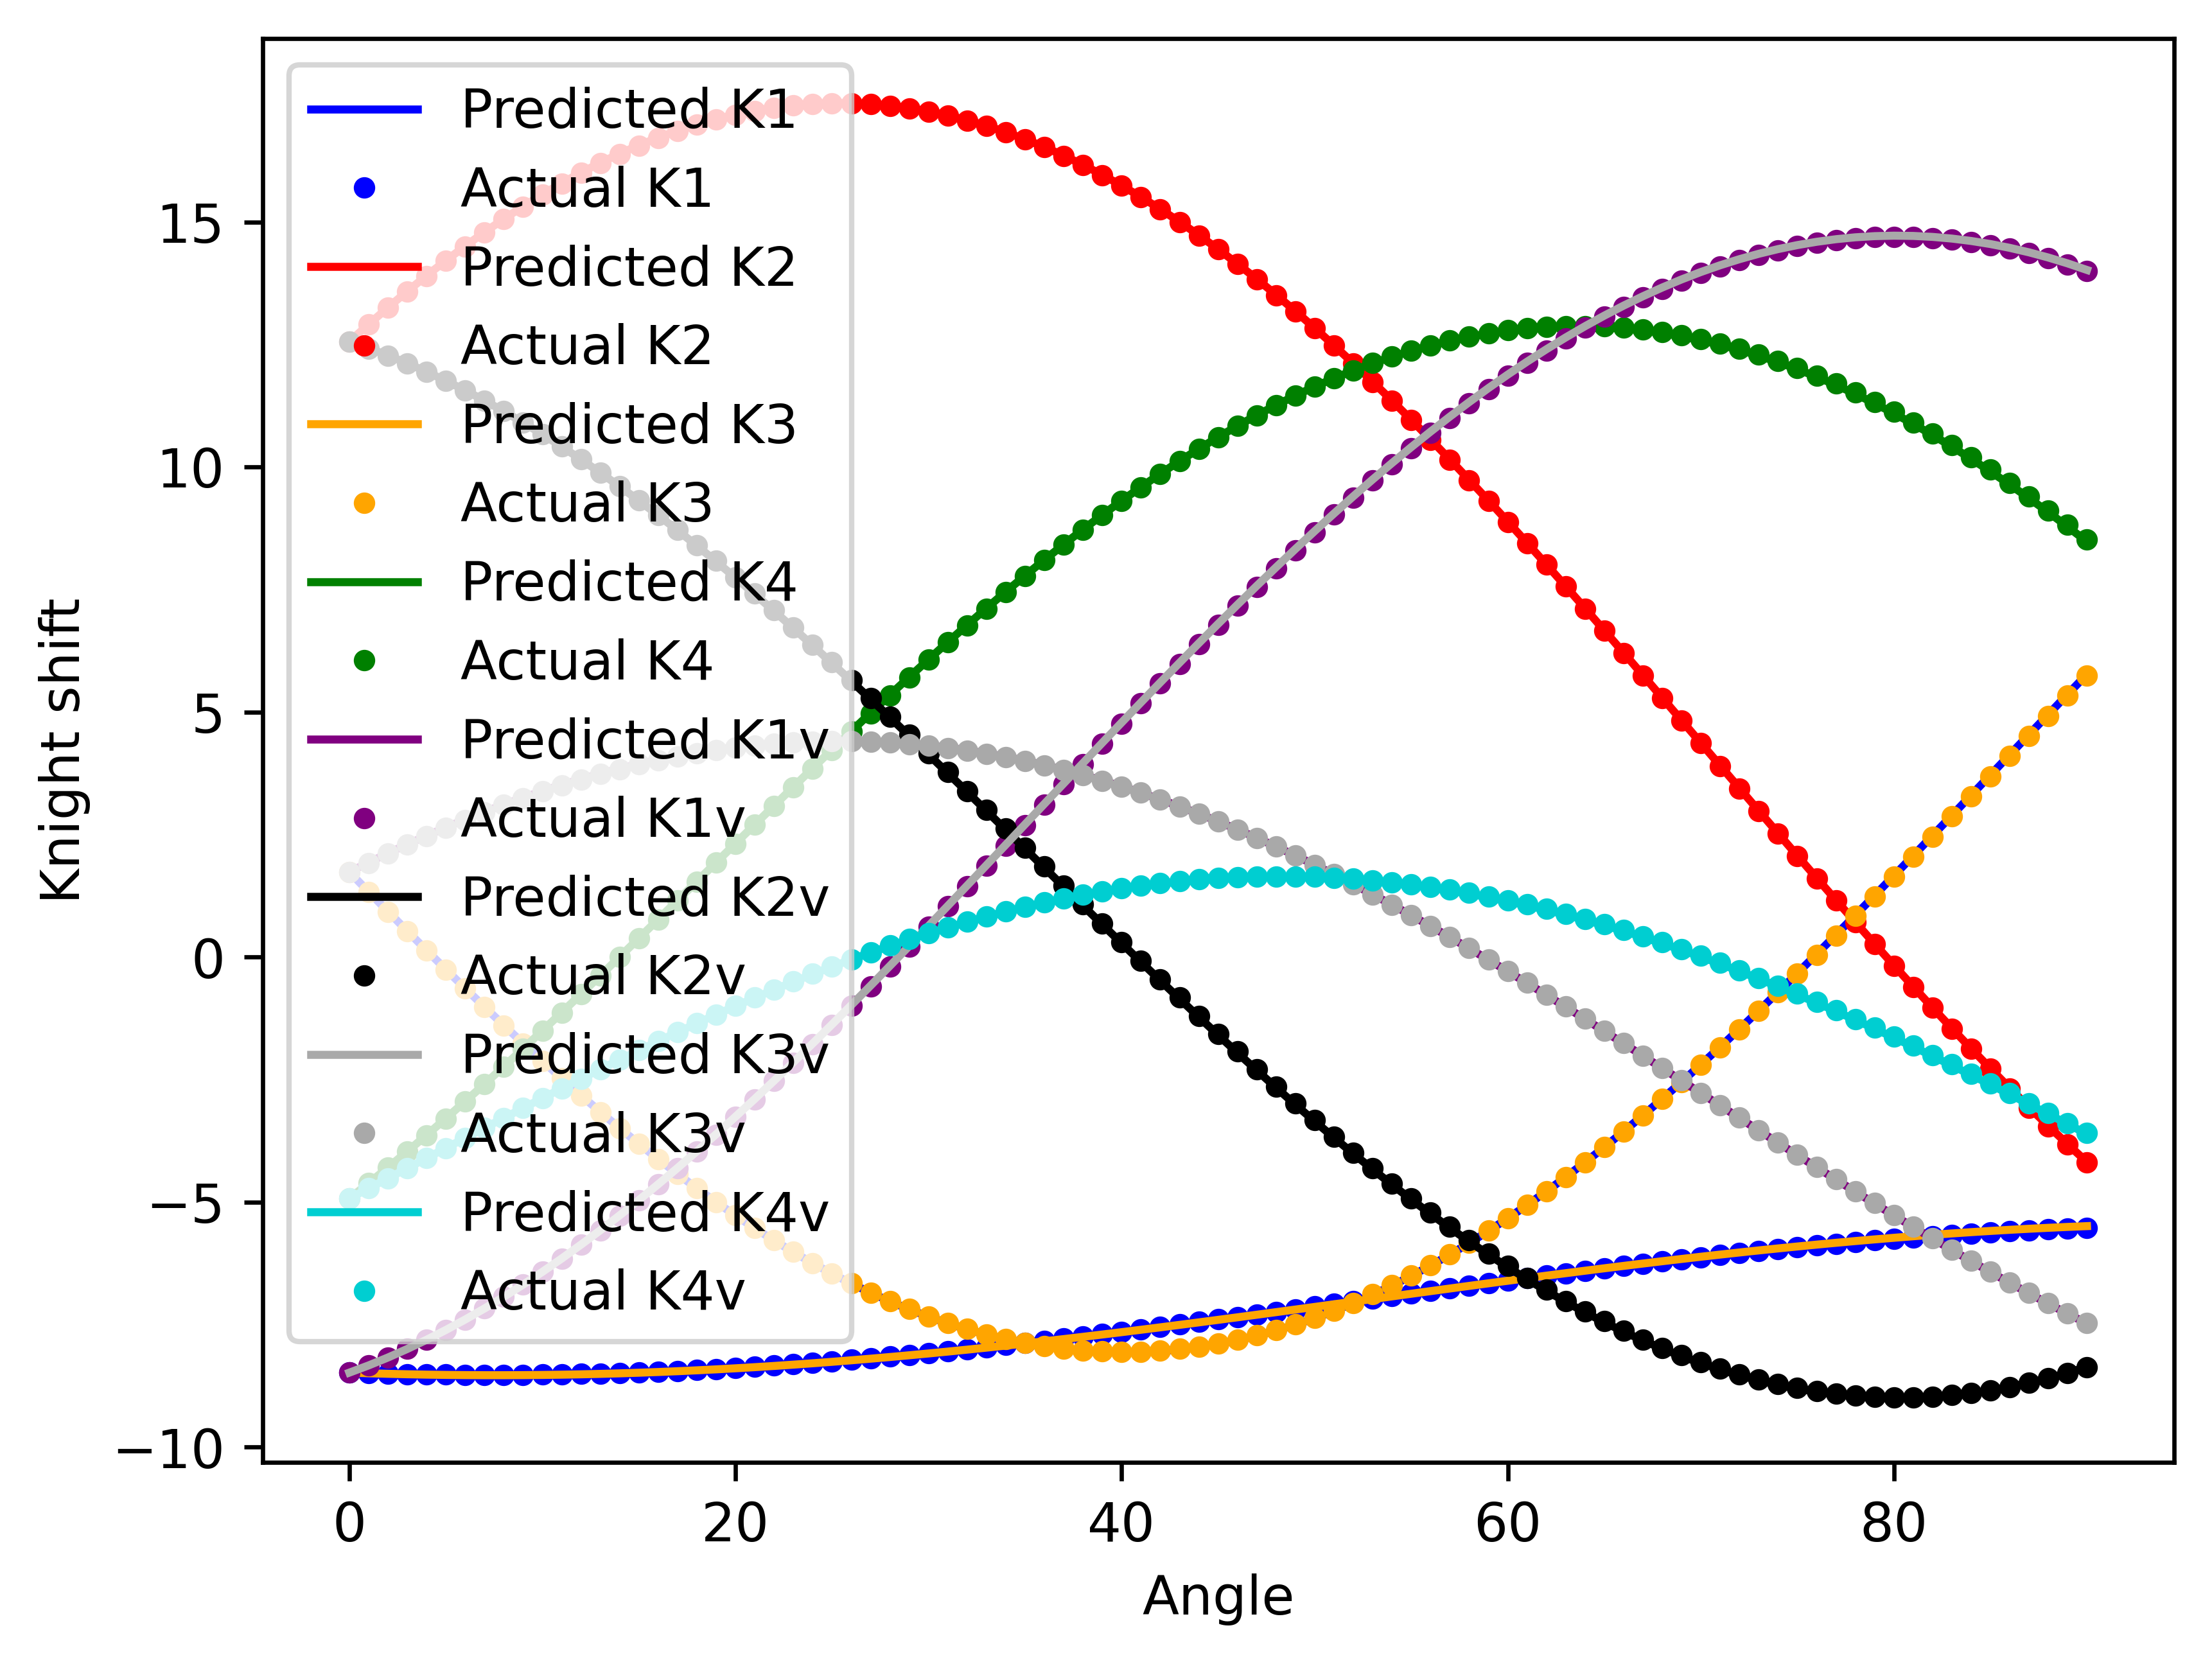

{'k1': -8.009384155273438, 'k2': 13.0039644241333, 'k3': -5.00014591217041, 'k4': -11.011630058288574, 'k5': 0.0, 'k6': 0.0, 't1': 44.04867935180664, 'p1': 102.30646514892578, 't2': 56.577728271484375, 'p2': -30.297441482543945}


In [11]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6, x7, x8]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift1'][3]
y_p5 = outputs[4]['shift2'][0]
y_p6 = outputs[5]['shift2'][1]
y_p7 = outputs[6]['shift2'][2]
y_p8 = outputs[7]['shift2'][3]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K4", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K4", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K1v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K1v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K2v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K2v", color = "black")

plt.plot(x7.detach().numpy(), y_p7.detach().numpy(), label="Predicted K3v", color = "darkgrey") 
plt.plot(x7.detach().numpy(), y7.numpy(), '.', label="Actual K3v", color = "darkgrey")

plt.plot(x8.detach().numpy(), y_p8.detach().numpy(), label="Predicted K4v", color = "darkturquoise") 
plt.plot(x8.detach().numpy(), y8.numpy(), '.', label="Actual K4v", color = "darkturquoise")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)